To evaluate the stability and scalability of the predictive models, I repeated the full modeling pipeline on two datasets of drastically different sizes: an initial 10,000-sample subset and a full 750,000-sample dataset. This comparison enables us to assess whether additional data improves predictive performance, alters model rankings, or reveals nonlinear structure not visible in smaller samples. The results across both classification and regression tasks reveal meaningful insights into the underlying structure of the phenotype and the limits of predictability in this simulated genomic environment.

1. Classification Models

    Across both sample sizes, linear models consistently outperformed or matched all alternatives. At 10,000 samples, Logistic Regression, LDA, and Linear SVM formed the top tier. At 750,000 samples, the ordering remained nearly identical, with LDA and Logistic Regression again taking the top two positions. Importantly, the overall level of predictive performance did not meaningfully change: accuracy remained around 0.68–0.69, and AUC values stayed tightly clustered around 0.75–0.76.

    Nonlinear models such as Gradient Boosting, Random Forests, and Decision Trees did improve with the larger dataset—particularly in terms of AUC—but still did not surpass the linear models. Their improvement suggests that the data contains some nonlinear signal, but the fact that they never overtake the linear baselines indicates that such structure is weak and contributes little to overall discrimination.

    Conclusion (Classification):
    The classification boundary appears to be fundamentally linear, with additional data producing only marginal gains. The predictive ceiling for this task lies around ~0.69 accuracy and ~0.76 AUC, and nonlinear approaches offer little advantage even at very large sample sizes.

2. Regression Models

    Regression results also show strong consistency between datasets. In both the 10k and 750k analyses, Linear Regression with PCA (and related linear models such as Ridge and Full Linear Regression with covariates) achieved the highest performance. At 10,000 samples, the top models achieved r² ≈ 0.5667, while in the full 750k dataset, performance stabilized around r² ≈ 0.5593.

    The slight decline in r² and increase in RMSE with the larger dataset is an expected phenomenon: smaller datasets often produce mildly inflated effect-size estimates due to overfitting to noise, whereas large datasets provide more conservative and accurate estimates of true predictive power. In other words, the 750k result represents a more realistic reflection of the phenotypic predictability given the available features.

    Tree-based regression models improved with additional data, as expected for higher-capacity models, but still fell short of the linear baselines. This provides further evidence that the governing relationship between predictors and outcome is dominated by linear, additive effects rather than complex interactions.

    Conclusion (Regression):
    The regression signal is near-entirely linear and additive. Increasing the dataset size did not reveal meaningful nonlinear effects, and linear models produce the most stable and accurate predictions. The true predictive ceiling for this phenotype appears to be r² ≈ 0.56.

3. Interpretation: What the Dataset Structure Tells Us

    The comparison between the two datasets leads to several consistent conclusions:

    The predictive signal is predominantly linear.
    Linear models remain the top performers across both classification and regression tasks, even when trained on 75× more data.

    There is substantial irreducible noise relative to the effect size.
    The limited improvement from 10k → 750k suggests that expanding sample size cannot overcome inherent variance in the phenotype.

    Nonlinear structure is weak or biologically insignificant.
    Tree-based and kernelized models improve but never surpass linear ones, even with massive sample support.

    Smaller datasets overestimate performance slightly, but not dramatically.
    The larger dataset provides more stable, conservative estimates of model capability, indicating that the 10k sample was mildly optimistic.

    The phenotype behaves like a classical polygenic trait.
    Additive PRS effects combined with additive environmental covariates create a structure that is best modeled—and almost fully captured—by linear methods.

### Overall Summary

Increasing the dataset from 10,000 to 750,000 samples did not meaningfully change model rankings or improve performance, indicating that the underlying relationship is stable, linear, and largely saturated by the available features. Both classification and regression tasks exhibit strong linearity and limited benefit from complex nonlinear models. These results suggest that the phenotype's predictability is fundamentally constrained by additive effects and inherent noise, rather than data scarcity.

This stability across dramatically different sample sizes strengthens confidence in the biological interpretation and in the robustness of the chosen modeling approaches.

# Imports and General Setup

Importing all necessary python packages, data, then establishing the variables I will be using throughout the notebook

In [64]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

sns.set(style="whitegrid", context="notebook")

In [65]:
cohort_path = "./msprime/C_msprime_sim_cohort.csv"

cohort = pd.read_csv(cohort_path)

In [66]:
numeric_features = ["age", "env_index", "polygenic_score", "quant_trait"]
categorical_features = ["sex"]
pcs_features = [col for col in cohort.columns if col.startswith("PC")]
numeric_pcs_features = numeric_features + pcs_features

SEED = 42

# EDA

## Cohort

In [67]:
cohort.isna().sum()

individual_id      0
sex                0
age                0
env_index          0
polygenic_score    0
quant_trait        0
disease_status     0
disease_prob       0
PC1                0
PC2                0
dtype: int64

In [68]:
cohort.isnull().sum()

individual_id      0
sex                0
age                0
env_index          0
polygenic_score    0
quant_trait        0
disease_status     0
disease_prob       0
PC1                0
PC2                0
dtype: int64

In [69]:
cohort.info()
cohort.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   individual_id    750000 non-null  int64  
 1   sex              750000 non-null  int64  
 2   age              750000 non-null  float64
 3   env_index        750000 non-null  float64
 4   polygenic_score  750000 non-null  float64
 5   quant_trait      750000 non-null  float64
 6   disease_status   750000 non-null  int64  
 7   disease_prob     750000 non-null  float64
 8   PC1              750000 non-null  float64
 9   PC2              750000 non-null  float64
dtypes: float64(7), int64(3)
memory usage: 57.2 MB


individual_id            sex            age      env_index  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean   374999.500000       0.499167      45.030840       0.001312   
std    216506.495284       0.500000      14.727595       1.000061   
min         0.000000       0.000000      20.000000      -4.951789   
25%    187499.750000       0.000000      32.000000      -0.674966   
50%    374999.500000       0.000000      45.000000       0.001437   
75%    562499.250000       1.000000      58.000000       0.676526   
max    749999.000000       1.000000      70.000000       4.468783   

       polygenic_score   quant_trait  disease_status   disease_prob  \
count     7.500000e+05  7.500000e+05   750000.000000  750000.000000   
mean      2.515321e-17 -1.072446e-17        0.501677       0.501566   
std       9.999999e-01  1.000000e+00        0.499998       0.224016   
min      -4.375721e+00 -4.527380e+00        0.000000       0.006382   
25%      -6.860924e-01 -6.743777e-01        0.000000       0.321854   
50%       3.245211e-02  1.196136e-02        1.000000       0.505956   
75%       7.373527e-01  6.850312e-01        1.000000       0.683772   
max       3.438454e+00  4.254360e+00        1.000000       0.988743   

                PC1           PC2  
count  7.500000e+05  7.500000e+05  
mean  -1.003476e-15  1.181907e-15  
std    8.800382e+00  7.999388e+00  
min   -1.621880e+01 -3.881475e+01  
25%   -6.284283e+00 -5.142902e+00  
50%   -1.616566e+00  1.367423e-01  
75%    3.975278e+00  5.361883e+00  
max    4.956955e+01  3.415391e+01

Quick overviews of the data to understand the number of columns, column datatypes, any missing data, and the summary stats of each column (count, mean, std, min, Q1, median, Q3, and max)

## Age

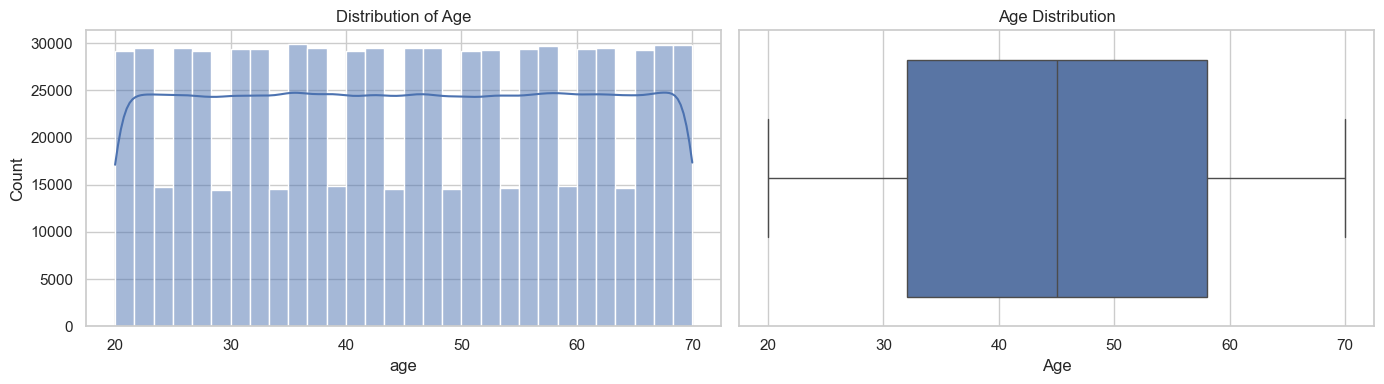

count    750000.000000
mean         45.030840
std          14.727595
min          20.000000
25%          32.000000
50%          45.000000
75%          58.000000
max          70.000000
Name: age, dtype: float64

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(cohort["age"], kde=True, bins=30, ax=axes[0])
axes[0].set_title("Distribution of Age")

sns.boxplot(x=cohort["age"], ax=axes[1])
axes[1].set_title("Age Distribution")
axes[1].set_xlabel("Age")

plt.tight_layout()
plt.show()

cohort["age"].describe()

## Env Index

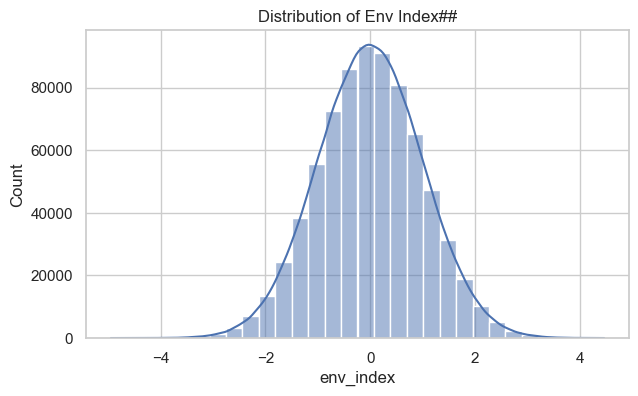

count    750000.000000
mean          0.001312
std           1.000061
min          -4.951789
25%          -0.674966
50%           0.001437
75%           0.676526
max           4.468783
Name: env_index, dtype: float64

In [71]:
plt.figure(figsize=(7,4))
sns.histplot(cohort["env_index"], kde=True, bins=30)
plt.title("Distribution of Env Index##")
plt.show()

cohort["env_index"].describe()

## Polygenic Score

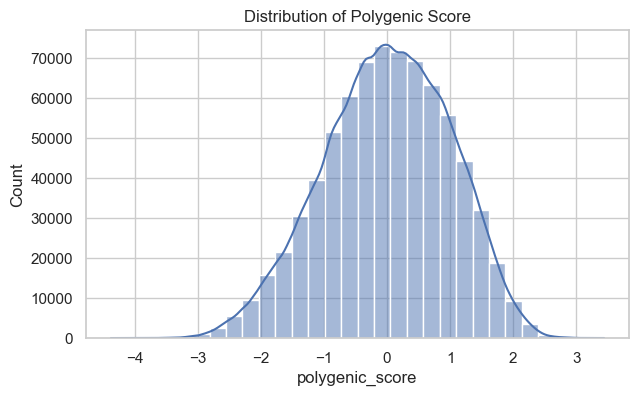

count    7.500000e+05
mean     2.515321e-17
std      9.999999e-01
min     -4.375721e+00
25%     -6.860924e-01
50%      3.245211e-02
75%      7.373527e-01
max      3.438454e+00
Name: polygenic_score, dtype: float64

In [72]:
plt.figure(figsize=(7,4))
sns.histplot(cohort["polygenic_score"], kde=True, bins=30)
plt.title("Distribution of Polygenic Score")
plt.show()

cohort["polygenic_score"].describe()

## Quant Trait

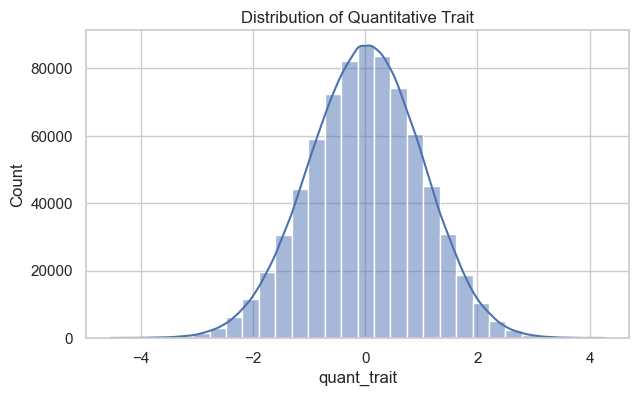

count    7.500000e+05
mean    -1.072446e-17
std      1.000000e+00
min     -4.527380e+00
25%     -6.743777e-01
50%      1.196136e-02
75%      6.850312e-01
max      4.254360e+00
Name: quant_trait, dtype: float64

In [73]:
plt.figure(figsize=(7,4))
sns.histplot(cohort["quant_trait"], kde=True, bins=30)
plt.title("Distribution of Quantitative Trait")
plt.show()

cohort["quant_trait"].describe()

## Disease Prob

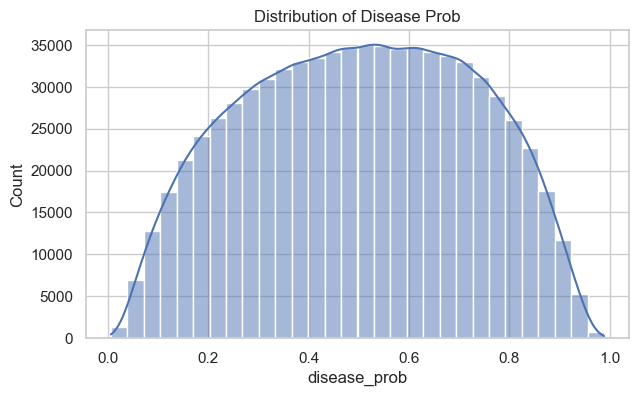

count    750000.000000
mean          0.501566
std           0.224016
min           0.006382
25%           0.321854
50%           0.505956
75%           0.683772
max           0.988743
Name: disease_prob, dtype: float64

In [74]:
plt.figure(figsize=(7,4))
sns.histplot(cohort["disease_prob"], kde=True, bins=30)
plt.title("Distribution of Disease Prob")
plt.show()

cohort["disease_prob"].describe()

## PC1

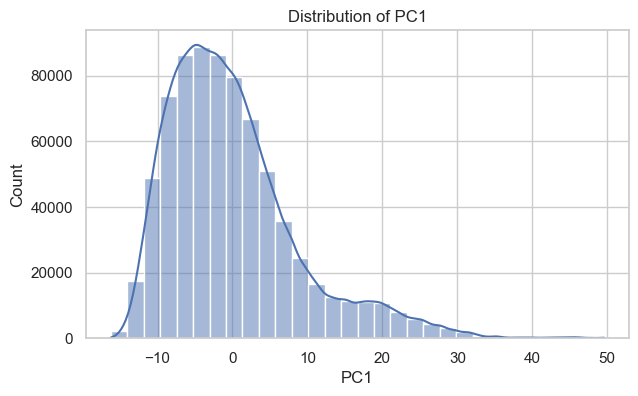

count    7.500000e+05
mean    -1.003476e-15
std      8.800382e+00
min     -1.621880e+01
25%     -6.284283e+00
50%     -1.616566e+00
75%      3.975278e+00
max      4.956955e+01
Name: PC1, dtype: float64

In [75]:
plt.figure(figsize=(7,4))
sns.histplot(cohort["PC1"], kde=True, bins=30)
plt.title("Distribution of PC1")
plt.show()

cohort["PC1"].describe()

## PC2

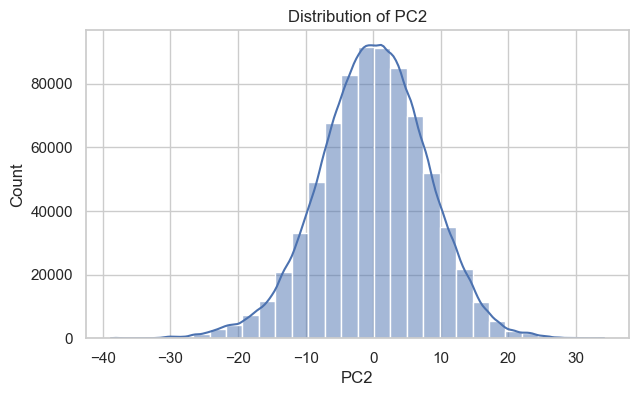

count    7.500000e+05
mean     1.181907e-15
std      7.999388e+00
min     -3.881475e+01
25%     -5.142902e+00
50%      1.367423e-01
75%      5.361883e+00
max      3.415391e+01
Name: PC2, dtype: float64

In [76]:
plt.figure(figsize=(7,4))
sns.histplot(cohort["PC2"], kde=True, bins=30)
plt.title("Distribution of PC2")
plt.show()

cohort["PC2"].describe()

## Sex

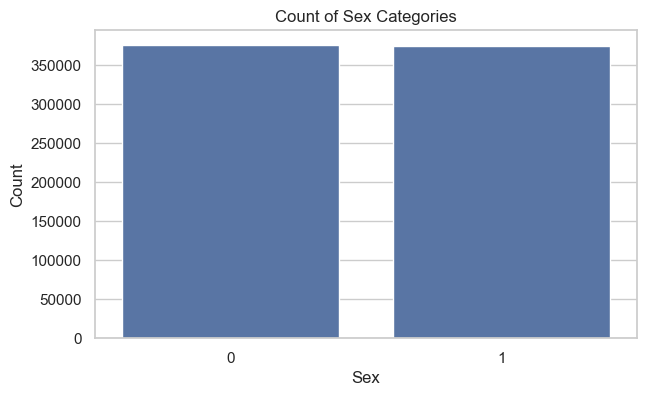

count    750000.000000
mean          0.499167
std           0.500000
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: sex, dtype: float64

In [77]:
plt.figure(figsize=(7,4))
sns.countplot(x="sex", data=cohort)
plt.title("Count of Sex Categories")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()

cohort["sex"].describe()

## Disease Status

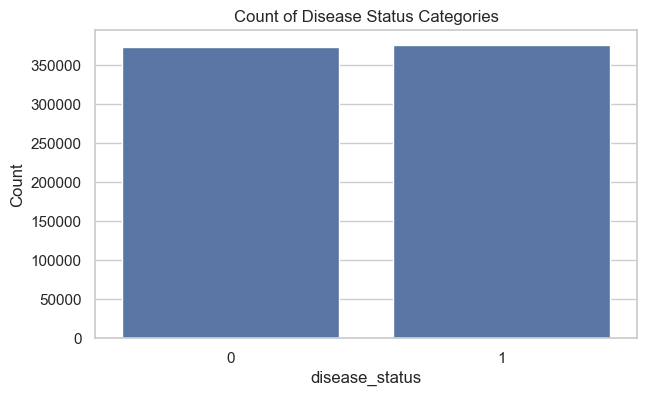

count    750000.000000
mean          0.501677
std           0.499998
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: disease_status, dtype: float64

In [78]:
plt.figure(figsize=(7,4))
sns.countplot(x="disease_status", data=cohort)
plt.title("Count of Disease Status Categories")
plt.xlabel("disease_status")
plt.ylabel("Count")
plt.show()

cohort["disease_status"].describe()

## Correlations

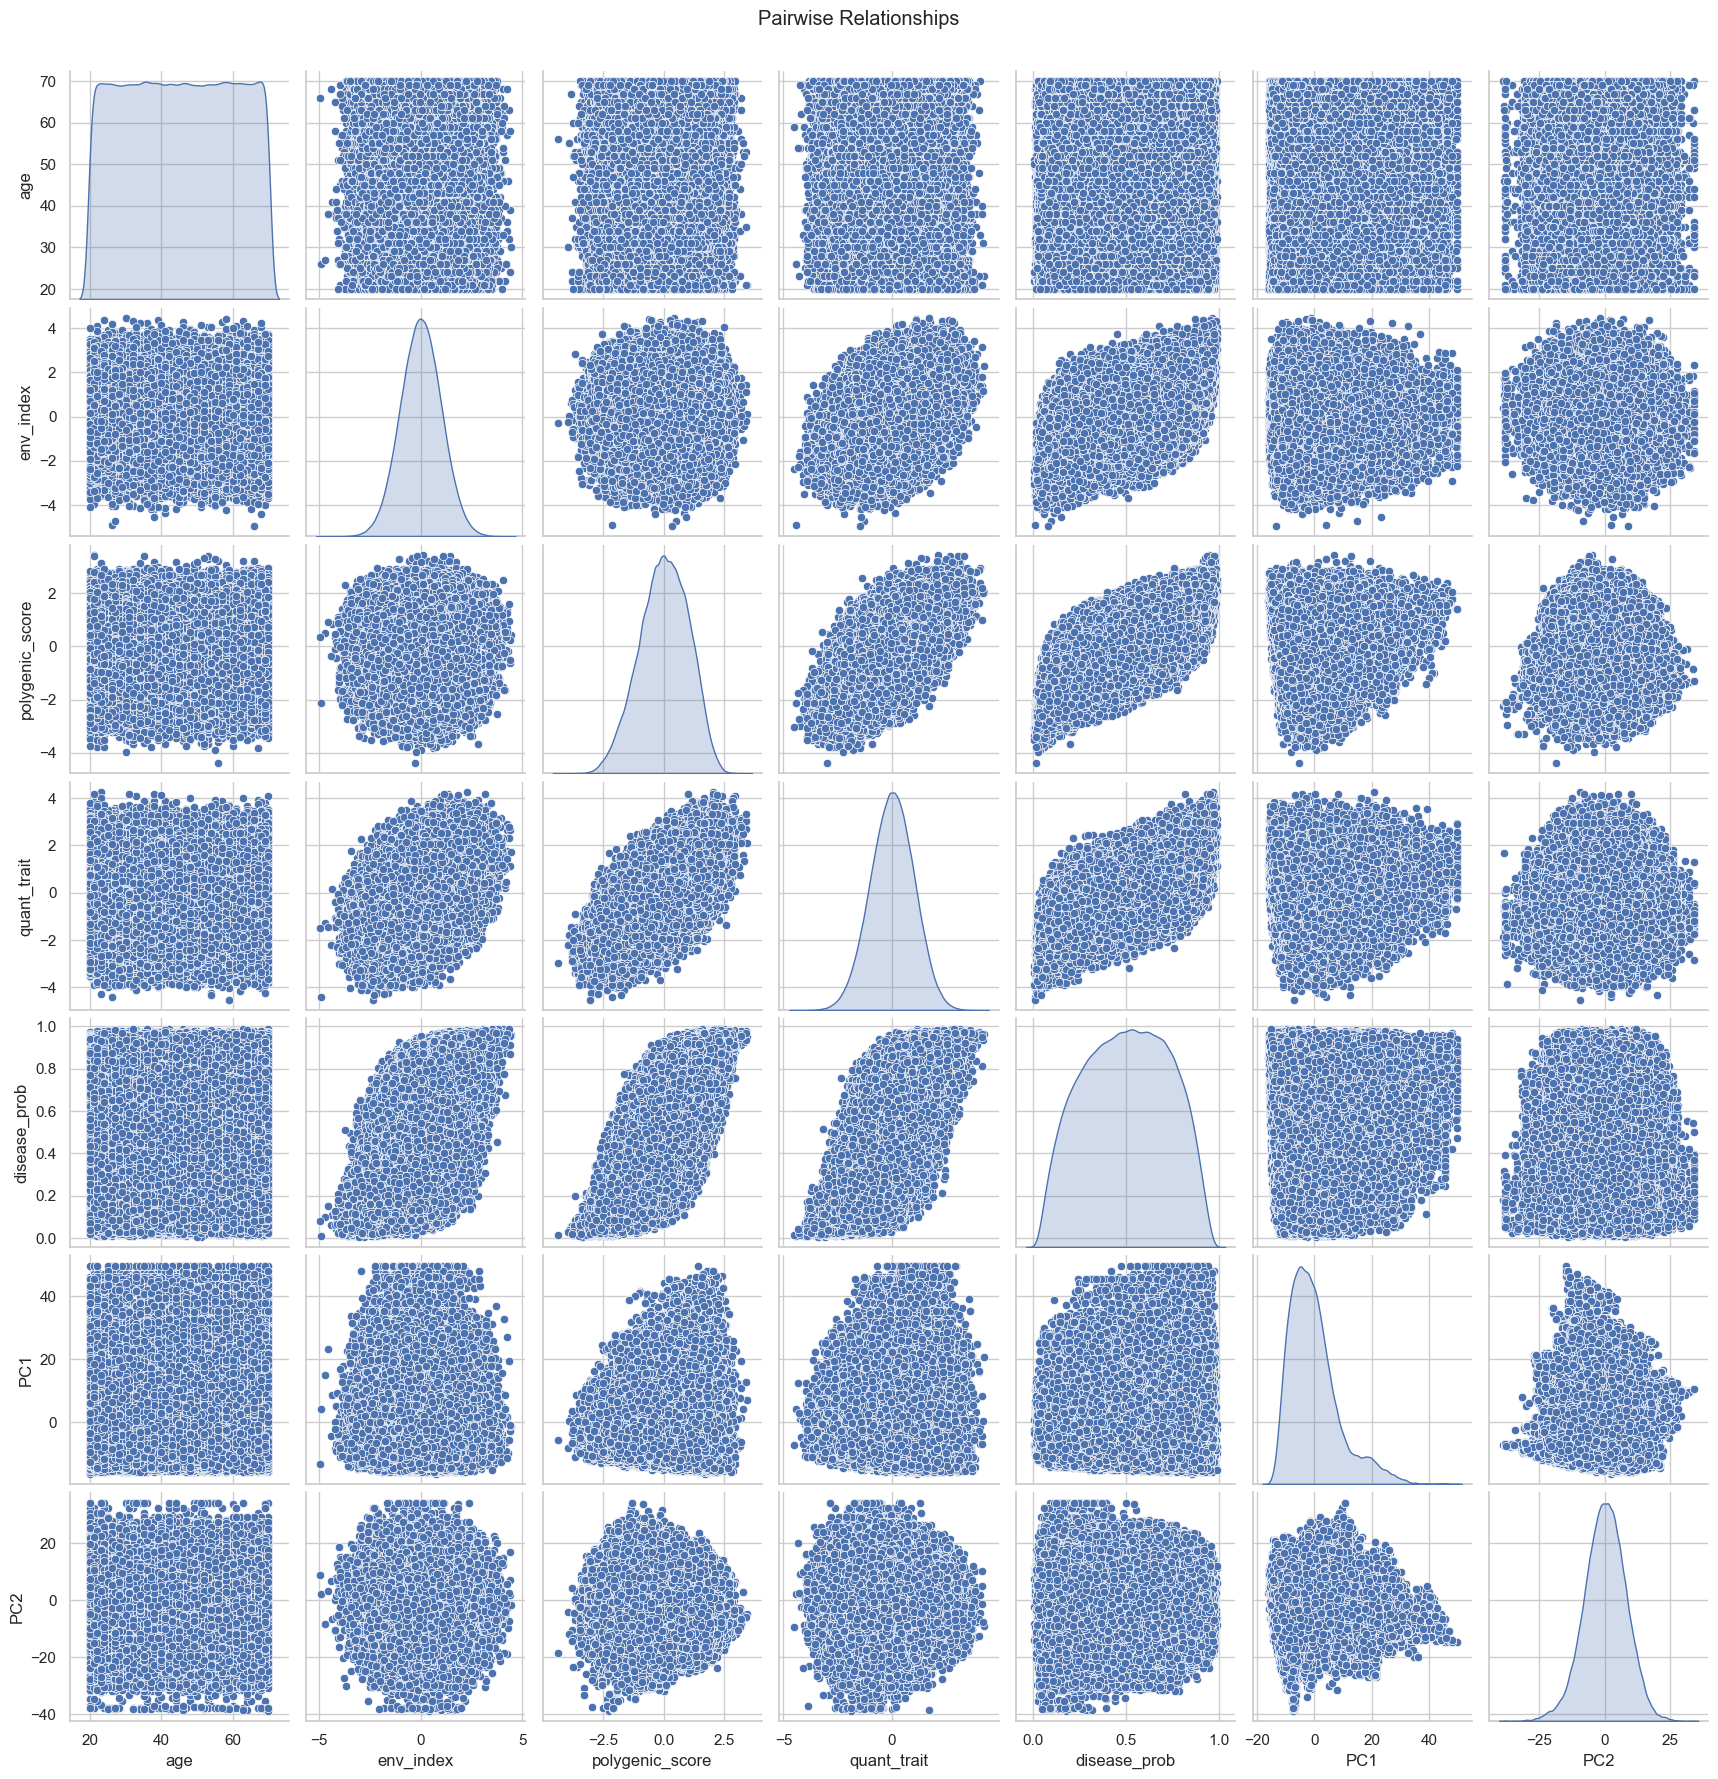

age  env_index  polygenic_score  quant_trait  \
age              1.000000   0.000107         0.001112     0.012537   
env_index        0.000107   1.000000        -0.000363     0.331677   
polygenic_score  0.001112  -0.000363         1.000000     0.662405   
quant_trait      0.012537   0.331677         0.662405     1.000000   
disease_prob     0.027743   0.534283         0.814639     0.735020   
PC1             -0.001242  -0.000859         0.019538     0.011472   
PC2             -0.000807   0.001657        -0.148688    -0.098090   

                 disease_prob           PC1           PC2  
age                  0.027743 -1.242368e-03 -8.067070e-04  
env_index            0.534283 -8.588128e-04  1.657454e-03  
polygenic_score      0.814639  1.953826e-02 -1.486880e-01  
quant_trait          0.735020  1.147245e-02 -9.808984e-02  
disease_prob         1.000000  1.607318e-02 -1.218015e-01  
PC1                  0.016073  1.000000e+00  6.515124e-15  
PC2                 -0.121802  6.515124e-15  1.000000e+00

In [79]:
cohort_numerical_vars = ["age", "env_index", "polygenic_score", "quant_trait", "disease_prob", "PC1", "PC2"]
sns.pairplot(cohort[cohort_numerical_vars], diag_kind="kde")
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()

cohort[cohort_numerical_vars].corr()

In [80]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = cohort[cohort_numerical_vars]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] = X.columns
print(vif)

         VIF          Feature
0  10.140698              age
1   1.801651        env_index
2   3.275983  polygenic_score
3   2.218100      quant_trait
4  12.050763     disease_prob
5   1.000399              PC1
6   1.022622              PC2


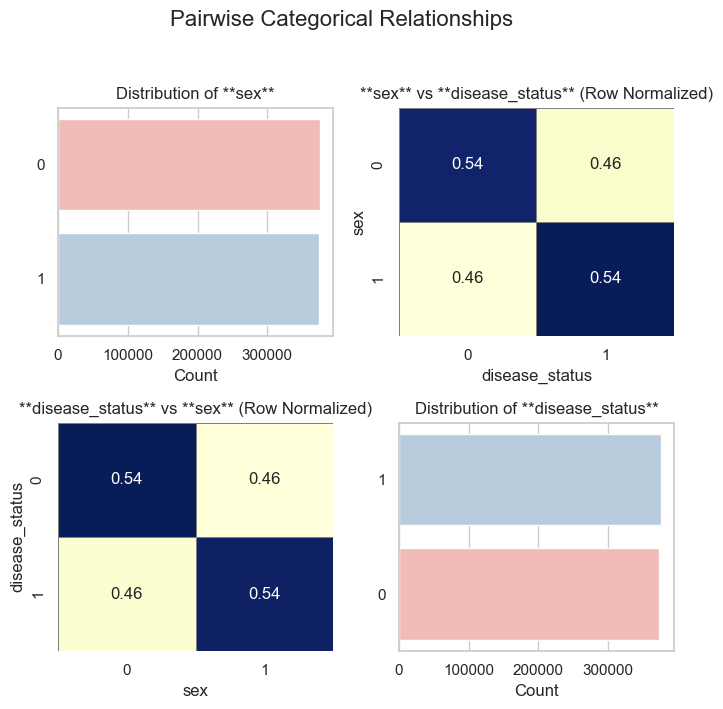

In [81]:
cohort_categorical_vars = ["sex", "disease_status"]
n_cohort_categorical_vars = len(cohort_categorical_vars)

fig, axes = plt.subplots(n_cohort_categorical_vars, n_cohort_categorical_vars, figsize=(n_cohort_categorical_vars * 3.5, n_cohort_categorical_vars * 3.5))
plt.suptitle("Pairwise Categorical Relationships", y=1.01, fontsize=16)

for i in range(n_cohort_categorical_vars):
    for j in range(n_cohort_categorical_vars):
        var1 = cohort_categorical_vars[i]
        var2 = cohort_categorical_vars[j]

        if i == j:
            sns.countplot(
                y=cohort[var1],
                ax=axes[i, j],
                hue=cohort[var1],
                palette="Pastel1",
                order=cohort[var1].value_counts().index,
                legend=False
            )
            axes[i, j].set_title(f"Distribution of **{var1}**", fontsize=12)
            axes[i, j].set_ylabel("")
            axes[i, j].set_xlabel("Count")

        else:
            contingency_table = pd.crosstab(cohort[var1], cohort[var2], normalize='index')
            sns.heatmap(
                contingency_table,
                annot=True,
                fmt=".2f",
                cmap="YlGnBu",
                cbar=False,
                ax=axes[i, j],
                linewidths=.5,
                linecolor='gray'
            )
            axes[i, j].set_title(f"**{var1}** vs **{var2}** (Row Normalized)", fontsize=12)
            axes[i, j].set_ylabel(var1)
            axes[i, j].set_xlabel(var2)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## Variables vs Trait

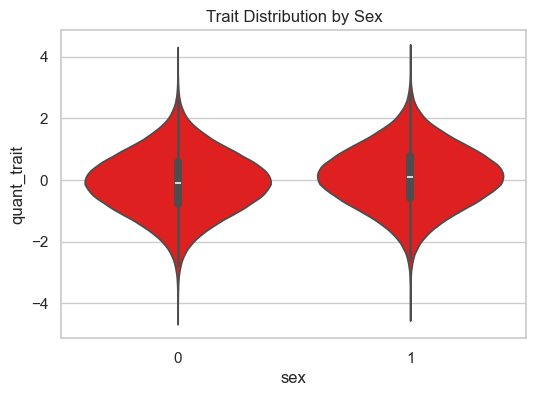

In [82]:
plt.figure(figsize=(6,4))
sns.violinplot(x=cohort["sex"], y=cohort["quant_trait"], color="red")
plt.title("Trait Distribution by Sex")
plt.show()

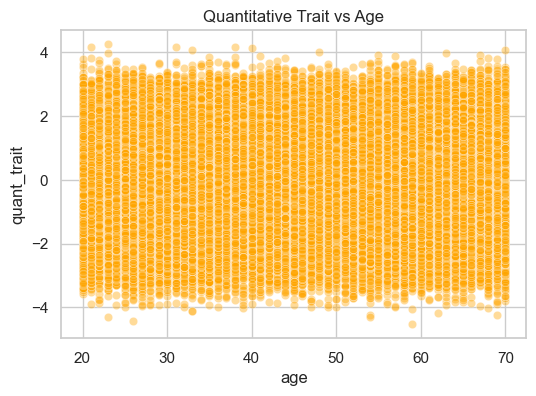

In [83]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=cohort["age"], y=cohort["quant_trait"], alpha=0.4, color="orange")
plt.title("Quantitative Trait vs Age")
plt.show()

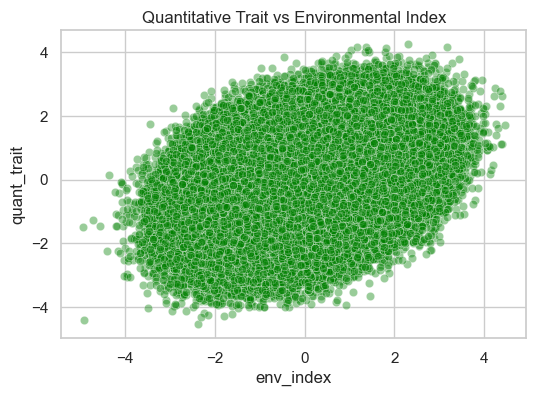

In [84]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=cohort["env_index"], y=cohort["quant_trait"], alpha=0.4, color="green")
plt.title("Quantitative Trait vs Environmental Index")
plt.show()

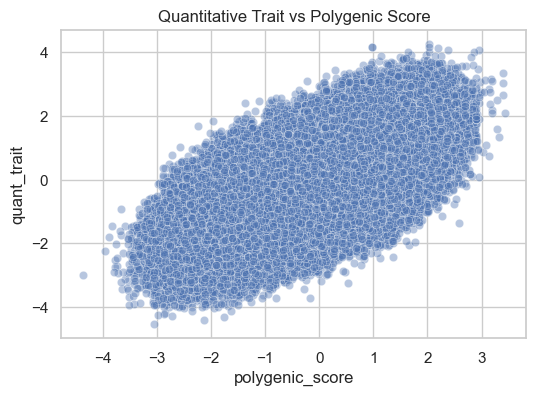

In [85]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=cohort["polygenic_score"], y=cohort["quant_trait"], alpha=0.4)
plt.title("Quantitative Trait vs Polygenic Score")
plt.show()

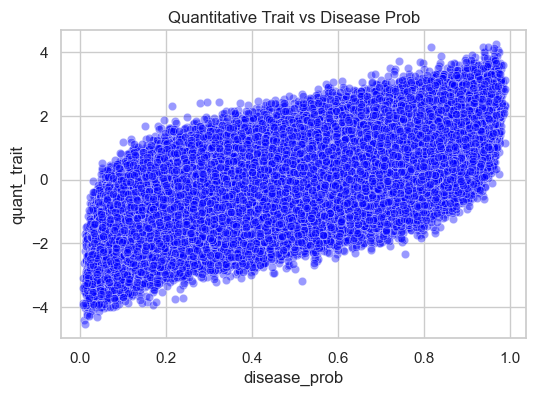

In [86]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=cohort["disease_prob"], y=cohort["quant_trait"], alpha=0.4, color="blue")
plt.title("Quantitative Trait vs Disease Prob")
plt.show()

## Correlation Matrix

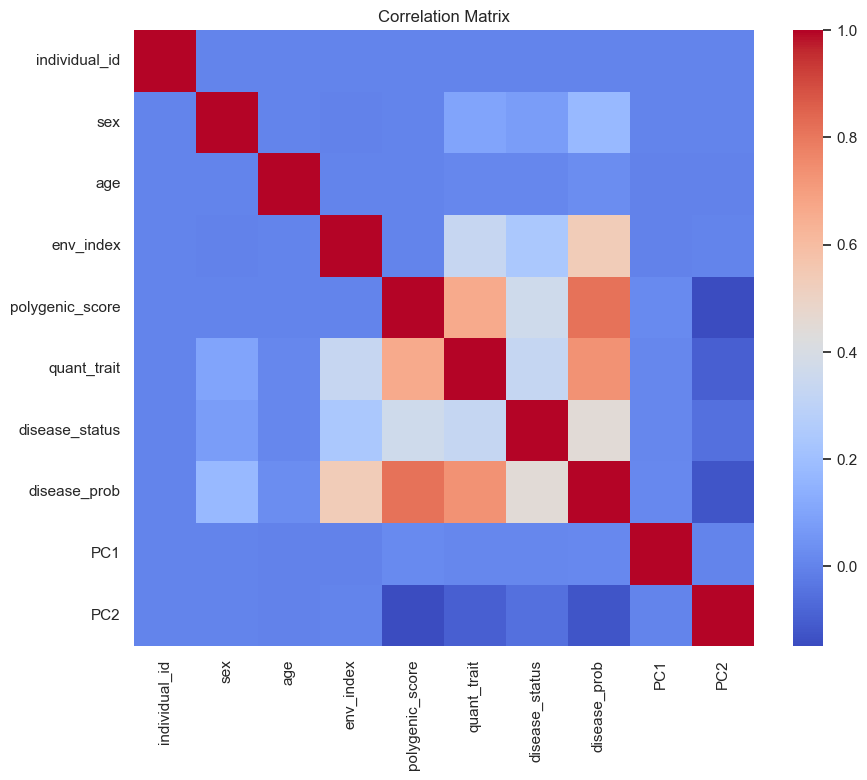

In [87]:
plt.figure(figsize=(10,8))
sns.heatmap(cohort.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## PCA Scatterplot

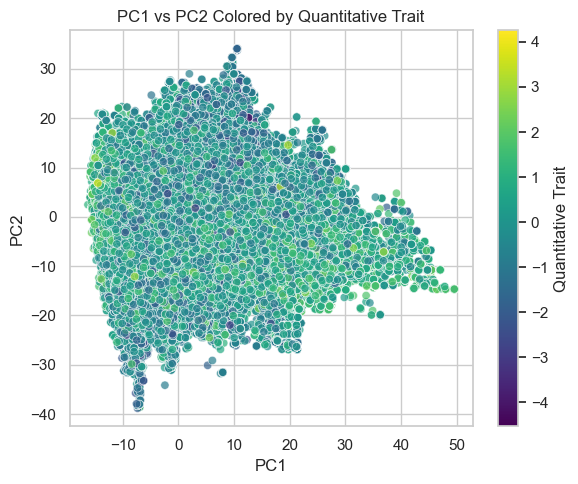

In [88]:
plt.figure(figsize=(6,5))

ax = plt.gca()

scatter = sns.scatterplot(
    x="PC1",
    y="PC2",
    data=cohort,
    hue="quant_trait",
    palette="viridis",
    alpha=0.7,
    legend=False,
    ax=ax
)

# Create normalization and ScalarMappable
norm = plt.Normalize(cohort["quant_trait"].min(), cohort["quant_trait"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

# Add colorbar **and tell it to use this Axes**
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Quantitative Trait")

# Labels and title
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PC1 vs PC2 Colored by Quantitative Trait")

plt.tight_layout()
plt.show()

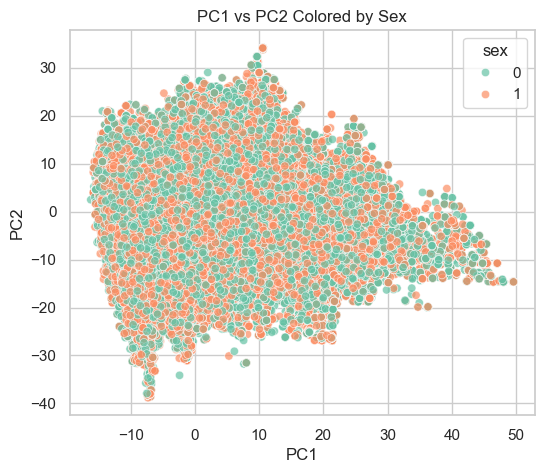

In [89]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=cohort,
    hue="sex",
    palette="Set2",
    alpha=0.7
)
plt.title("PC1 vs PC2 Colored by Sex")
plt.show()

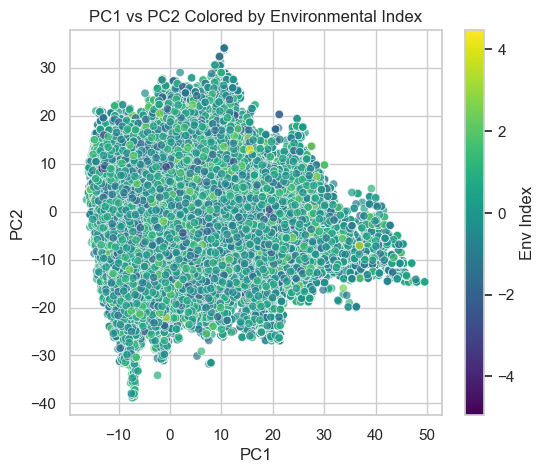

In [90]:
from matplotlib.colors import Normalize

fig, ax = plt.subplots(figsize=(6, 5))

sns.scatterplot(
    x="PC1",
    y="PC2",
    data=cohort,
    hue="env_index",
    palette="viridis",
    alpha=0.7,
    legend=False,
    ax=ax
)

# Add colorbar manually
norm = Normalize(cohort["env_index"].min(), cohort["env_index"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

fig.colorbar(sm, ax=ax, label="Env Index")

ax.set_title("PC1 vs PC2 Colored by Environmental Index")
plt.show()

## Outlier Detection

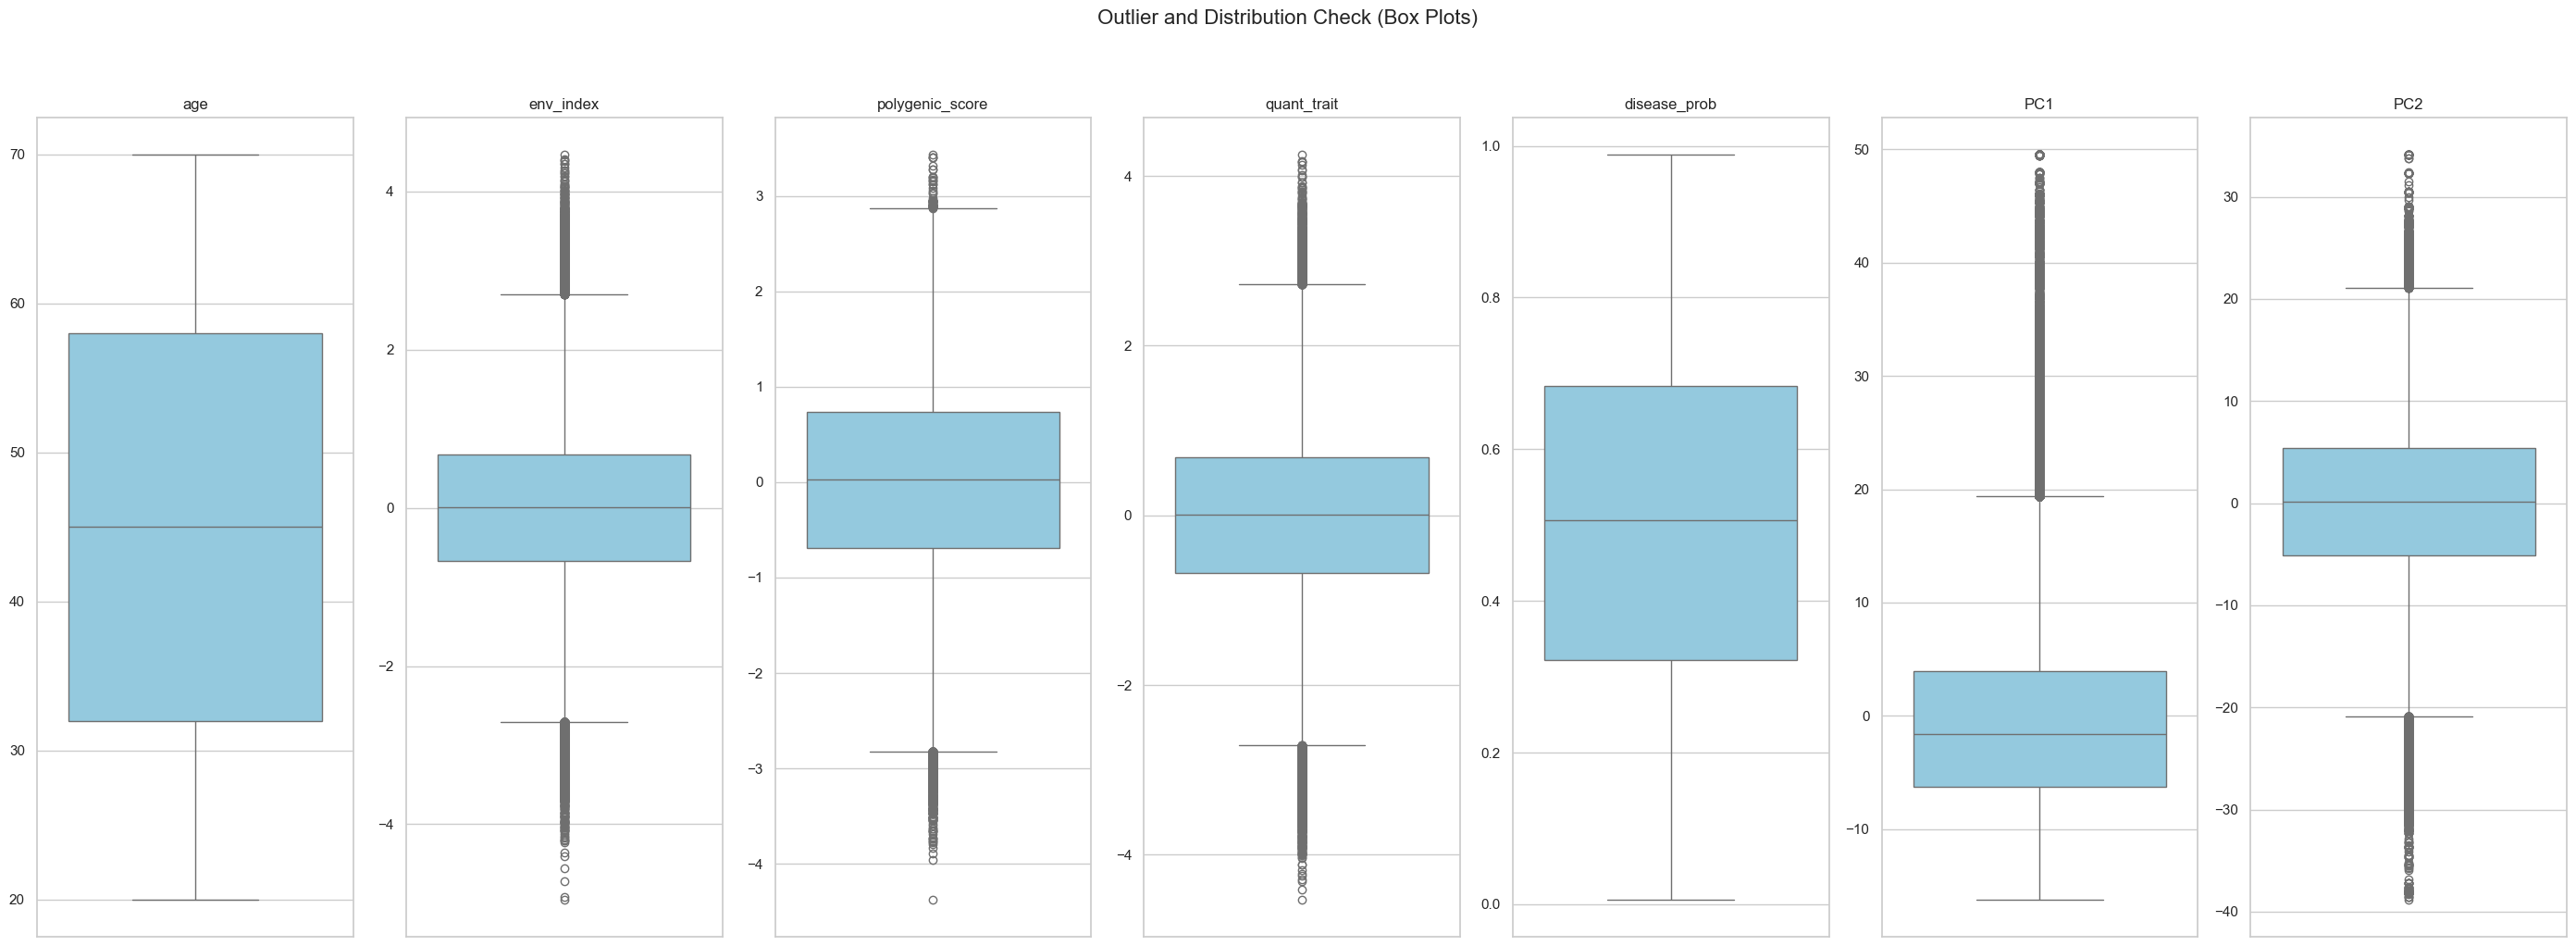

In [91]:
cohort_n_numerical_cols = len(cohort_numerical_vars)

fig, axes = plt.subplots(1, cohort_n_numerical_cols, figsize=(4 * cohort_n_numerical_cols, 10))
plt.suptitle("Outlier and Distribution Check (Box Plots)", fontsize=16, y=1.02)

for i, col in enumerate(cohort_numerical_vars):
    sns.boxplot(y=cohort[col], ax=axes[i], color='skyblue')
    axes[i].set_title(col, fontsize=12)
    axes[i].set_ylabel("")

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## Z-Scores

In [92]:
from scipy.stats import zscore

# Calculate z-scores
cohort["age_z"] = zscore(cohort["age"])
cohort["env_index_z"] = zscore(cohort["env_index"])
cohort["trait_z"] = zscore(cohort["quant_trait"])
cohort["pgs_z"] = zscore(cohort["polygenic_score"])
cohort["disease_prob_z"] = zscore(cohort["disease_prob"])
cohort["PC1_z"] = zscore(cohort["PC1"])
cohort["PC2_z"] = zscore(cohort["PC2"])

# Identify rows with extreme |z| > 3
age_outliers = cohort[cohort["age_z"].abs() > 3]
env_index_outliers = cohort[cohort["env_index_z"].abs() > 3]
trait_outliers = cohort[cohort["trait_z"].abs() > 3]
pgs_outliers = cohort[cohort["pgs_z"].abs() > 3]
disease_prob_outliers = cohort[cohort["disease_prob_z"].abs() > 3]
PC1_outliers = cohort[cohort["PC1_z"].abs() > 3]
PC2_outliers = cohort[cohort["PC2_z"].abs() > 3]

print(f"Count of Age Outliers: {len(age_outliers)}")
print(f"Count of Env Index Outliers: {len(env_index_outliers)}")
print(f"Count of Trait Outliers: {len(trait_outliers)}")
print(f"Count of Polygenic Score Outliers: {len(pgs_outliers)}")
print(f"Count of Disease Prob Outliers: {len(disease_prob_outliers)}")
print(f"Count of PC1 Outliers: {len(PC1_outliers)}")
print(f"Count of PC2 Outliers: {len(PC2_outliers)}")

Count of Age Outliers: 0
Count of Env Index Outliers: 2048
Count of Trait Outliers: 1761
Count of Polygenic Score Outliers: 528
Count of Disease Prob Outliers: 0
Count of PC1 Outliers: 9732
Count of PC2 Outliers: 3693


# Setup Disease Status Classification

## Model Preparation

In [93]:
from sklearn.model_selection import train_test_split

X = cohort[numeric_features + pcs_features + categorical_features]
y = cohort["disease_status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=SEED
)

X_train.shape, X_test.shape

((525000, 7), (225000, 7))

## Standardization

In [94]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled_num = scaler.fit_transform(X_train[numeric_pcs_features])
X_train_scaled = pd.DataFrame(
    X_train_scaled_num,
    columns=numeric_pcs_features,
    index=X_train.index
)

X_test_scaled_num = scaler.transform(X_test[numeric_pcs_features])
X_test_scaled = pd.DataFrame(
    X_test_scaled_num,
    columns=numeric_pcs_features,
    index=X_test.index
)

X_train_scaled["sex"] = X_train["sex"].values
X_test_scaled["sex"] = X_test["sex"].values

X_train_scaled.head()

age  env_index  polygenic_score  quant_trait       PC1       PC2  \
6036   -0.206284  -1.470909         1.524975     1.187935 -1.272490  0.239766   
617631 -0.817624   2.181417         0.019218     0.191568  1.914633 -0.881347   
580701  0.405056  -1.188085        -0.352737     0.431638 -0.625959  0.442499   
696804 -1.225183   2.141173         0.173295     0.498567 -1.054864 -0.783709   
316225 -1.225183   1.805857         0.390879     0.669279  0.302336 -0.037086   

        sex  
6036      0  
617631    0  
580701    1  
696804    1  
316225    1

## Split Data Overview

In [95]:
core_vars = numeric_pcs_features + categorical_features

X_train_full = X_train_scaled[core_vars]
X_test_full = X_test_scaled[core_vars]

X_train_full.head()

age  env_index  polygenic_score  quant_trait       PC1       PC2  \
6036   -0.206284  -1.470909         1.524975     1.187935 -1.272490  0.239766   
617631 -0.817624   2.181417         0.019218     0.191568  1.914633 -0.881347   
580701  0.405056  -1.188085        -0.352737     0.431638 -0.625959  0.442499   
696804 -1.225183   2.141173         0.173295     0.498567 -1.054864 -0.783709   
316225 -1.225183   1.805857         0.390879     0.669279  0.302336 -0.037086   

        sex  
6036      0  
617631    0  
580701    1  
696804    1  
316225    1

In [96]:
X_train_scaled[numeric_features].mean(), X_train_scaled[numeric_features].std()

(age               -1.188433e-16
 env_index         -2.202006e-17
 polygenic_score   -2.982926e-17
 quant_trait        1.689738e-17
 dtype: float64,
 age                1.000001
 env_index          1.000001
 polygenic_score    1.000001
 quant_trait        1.000001
 dtype: float64)

In [97]:
X_test_scaled[numeric_features].mean(), X_test_scaled[numeric_features].std()

(age               -0.001365
 env_index         -0.004235
 polygenic_score   -0.001211
 quant_trait       -0.003374
 dtype: float64,
 age                1.001318
 env_index          1.003077
 polygenic_score    1.000985
 quant_trait        1.003036
 dtype: float64)

# Classification Models

Functions that will be used constantly for model evaluation

In [98]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, roc_curve, average_precision_score

def evaluate_and_graph_clf(model, X_train, y_train, X_test, y_test, name, graph):
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    if hasattr(model, "predict_proba"):
        y_prob_test = model.predict_proba(X_test)[:, 1]
        y_prob_train = model.predict_proba(X_train)[:, 1]
    else:
        y_prob_test = model.decision_function(X_test)
        y_prob_train = model.decision_function(X_train)

    test_acc = accuracy_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_prob_test)
    test_ap = average_precision_score(y_test, y_prob_test)

    train_acc = accuracy_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_prob_train)

    print(f"--- {name} ---")
    print(f"Train Accuracy: {train_acc:.4f} | Train AUC: {train_auc:.4f}")
    print(f"Test  Accuracy: {test_acc:.4f} | Test  AUC: {test_auc:.4f}")

    if (train_acc - test_acc) > 0.05:
         print("⚠️ Warning: Signs of Overfitting (Train is much better than Test)")
    else:
         print("✅ Model seems balanced")
    print("-" * 30)

    fpr, tpr, _ = roc_curve(y_test, y_prob_test)
    precision, recall, _ = precision_recall_curve(y_test, y_prob_test)

    if graph:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # --- Plot 1: ROC Curve ---
        axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {test_auc:.3f}')
        axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
        axes[0].set_xlim([0.0, 1.0])
        axes[0].set_ylim([0.0, 1.05])
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].set_title(f'ROC Curve: {name}')
        axes[0].legend(loc="lower right")
        axes[0].grid(True, alpha=0.3)

        # --- Plot 2: Precision-Recall Curve ---
        # "No Skill" baseline is just the percentage of positive cases
        no_skill = y_test.mean()

        axes[1].plot(recall, precision, color='green', lw=2, label=f'Avg Precision = {test_ap:.3f}')
        axes[1].plot([0, 1], [no_skill, no_skill], color='navy', linestyle='--', label='No Skill')
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('Recall')
        axes[1].set_ylabel('Precision')
        axes[1].set_title(f'PR Curve: {name}')
        axes[1].legend(loc="upper right")
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return {
        "model": name,
        "accuracy": test_acc,
        "auc": test_auc,
        "average_precision": test_ap,
        "train_accuracy": train_acc,
        "train_auc": train_auc
    }

def pick_best_model_clf(dataframe, overfit_threshold=0.05):
    if dataframe is None or dataframe.empty:
        print("No models provided (empty DataFrame).")
        return None

    df = dataframe.copy()

    df['overfitting_gap'] = df['train_auc'] - df['auc']
    df['is_overfit'] = df['overfitting_gap'] > overfit_threshold

    df_valid = df[df['is_overfit'] == False].copy()
    df_overfit = df[df['is_overfit'] == True].copy()

    print(f"Total Models: {len(df)}")
    print(f"Valid Models: {len(df_valid)}")
    print(f"Disqualified Models: {len(df_overfit)}")

    if not df_overfit.empty:
        print("\n⚠️ The following models were disqualified due to overfitting:")
        display(df_overfit[['model', 'accuracy', 'auc', 'train_auc', 'overfitting_gap']])
    else:
        print("\n✅ No models were disqualified for overfitting.")

    if df_valid.empty:
        print("\n⚠️ All models are overfitting (by the chosen threshold).")
        print("Falling back to ranking ALL models by AUC.")
        df_valid = df.copy()

    print("Best by Accuracy:")
    display(df_valid.sort_values(by="accuracy", ascending=False).head(1))

    print("Best by AUC:")
    display(df_valid.sort_values(by="auc", ascending=False).head(1))

    print("Best by Average Precision:")
    display(df_valid.sort_values(by="average_precision", ascending=False).head(1))

    df_valid_ranked = df_valid.copy()
    df_valid_ranked["rank_acc"] = df_valid["accuracy"].rank(ascending=False)
    df_valid_ranked["rank_auc"] = df_valid["auc"].rank(ascending=False)
    df_valid_ranked["rank_ap"] = df_valid["average_precision"].rank(ascending=False)


    final_ranking = df_valid_ranked.sort_values(
        by=["rank_auc", "rank_acc", "rank_ap"]
    )

    cols = ['model', 'accuracy', 'auc', 'average_precision', 'overfitting_gap']
    print("\nFinal ranking (higher = better):")
    display(final_ranking[cols])

    best_model_row = final_ranking.iloc[0]
    best_model_name = best_model_row['model']
    print(f"\n🏆 Best model: {best_model_name}")

    return best_model_name

## Bayes Classifier

--- Naive Bayes (Gaussian) ---
Train Accuracy: 0.6782 | Train AUC: 0.7421
Test  Accuracy: 0.6784 | Test  AUC: 0.7423
✅ Model seems balanced
------------------------------


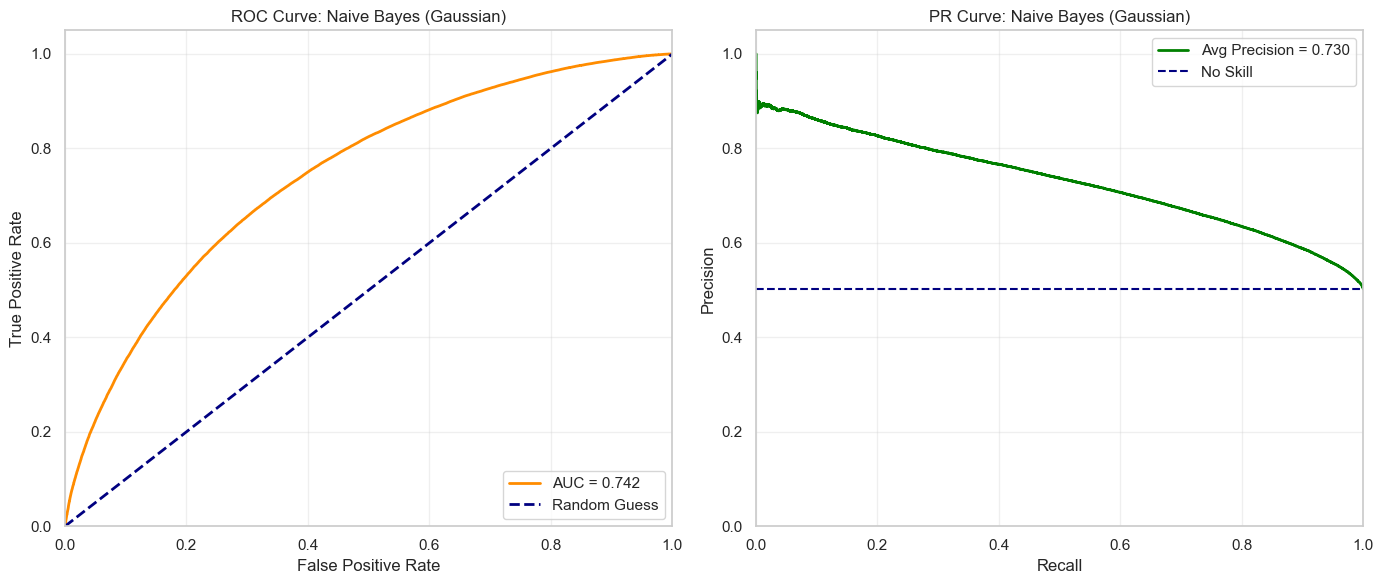

--- Naive Bayes (Bernoulli) ---
Train Accuracy: 0.6633 | Train AUC: 0.7176
Test  Accuracy: 0.6630 | Test  AUC: 0.7178
✅ Model seems balanced
------------------------------


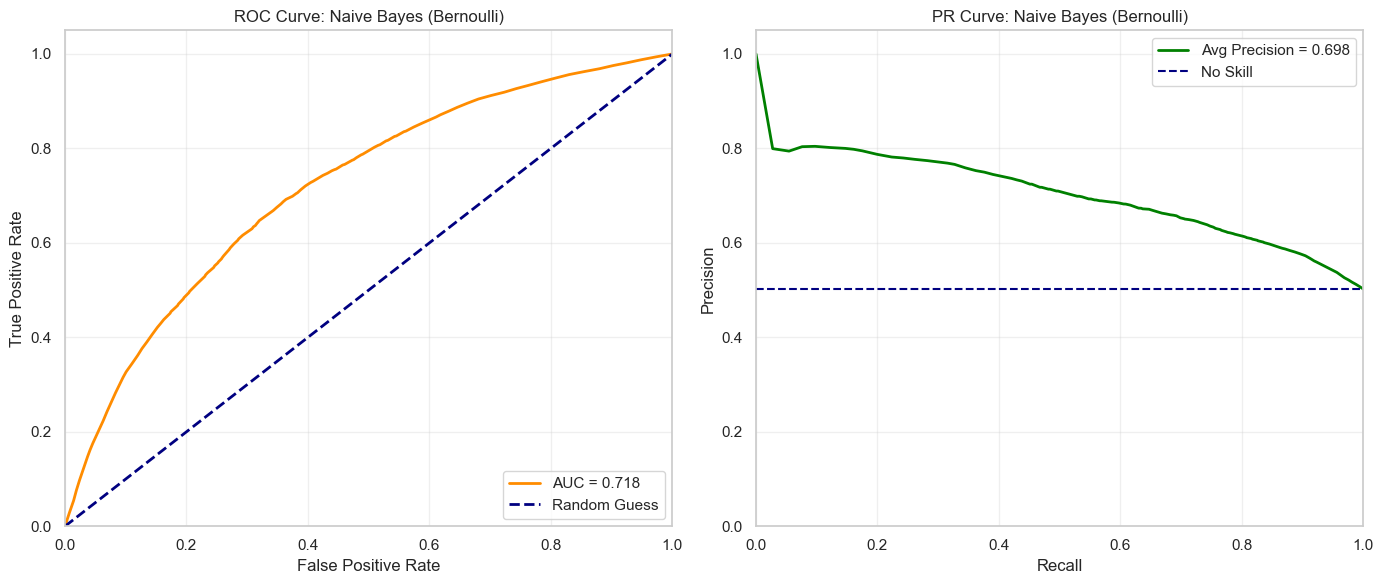

In [99]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

results_clf = []

gnb = GaussianNB()
results_clf.append(
    evaluate_and_graph_clf(gnb, X_train_full, y_train, X_test_full, y_test, "Naive Bayes (Gaussian)", True)
)

bnb = BernoulliNB()
results_clf.append(
    evaluate_and_graph_clf(bnb, X_train_full, y_train, X_test_full, y_test, "Naive Bayes (Bernoulli)", True)
)

## K-Nearest Neighbors

--- KNN (k=11) ---
Train Accuracy: 0.7216 | Train AUC: 0.7991
Test  Accuracy: 0.6632 | Test  AUC: 0.7174
⚠️ Warning: Signs of Overfitting (Train is much better than Test)
------------------------------


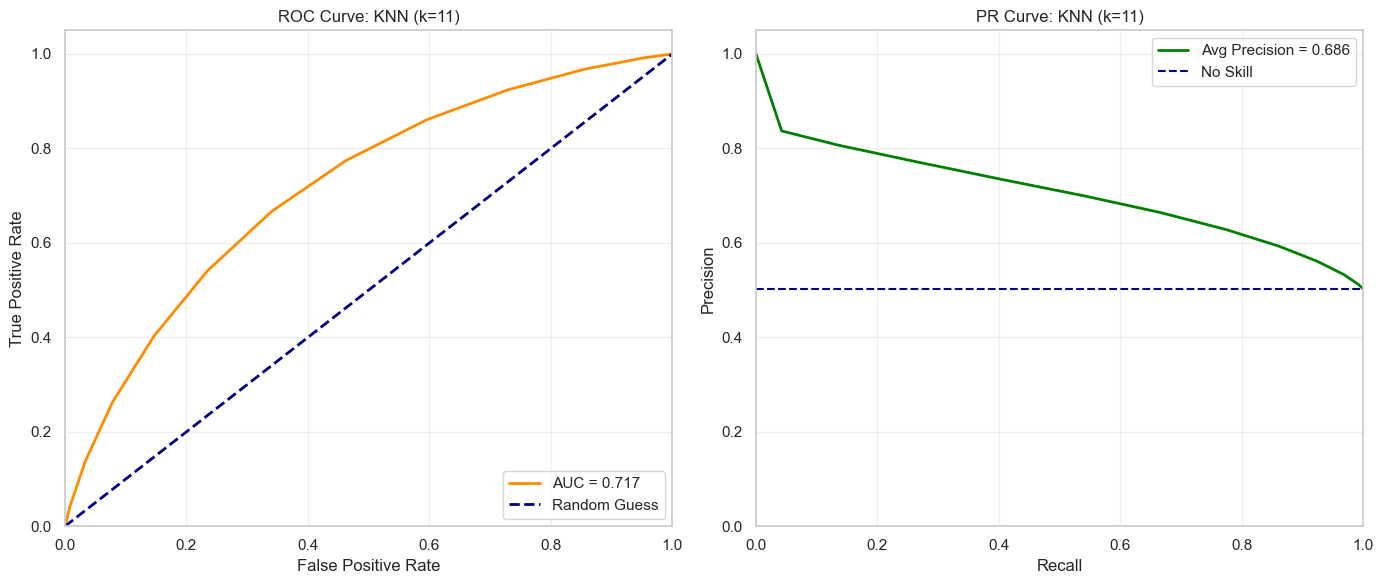

In [100]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=11)
results_clf.append(
    evaluate_and_graph_clf(knn, X_train_full, y_train, X_test_full, y_test, "KNN (k=11)", True)
)

## Logistic Regression

--- Logistic Regression ---
Train Accuracy: 0.6906 | Train AUC: 0.7584
Test  Accuracy: 0.6906 | Test  AUC: 0.7575
✅ Model seems balanced
------------------------------


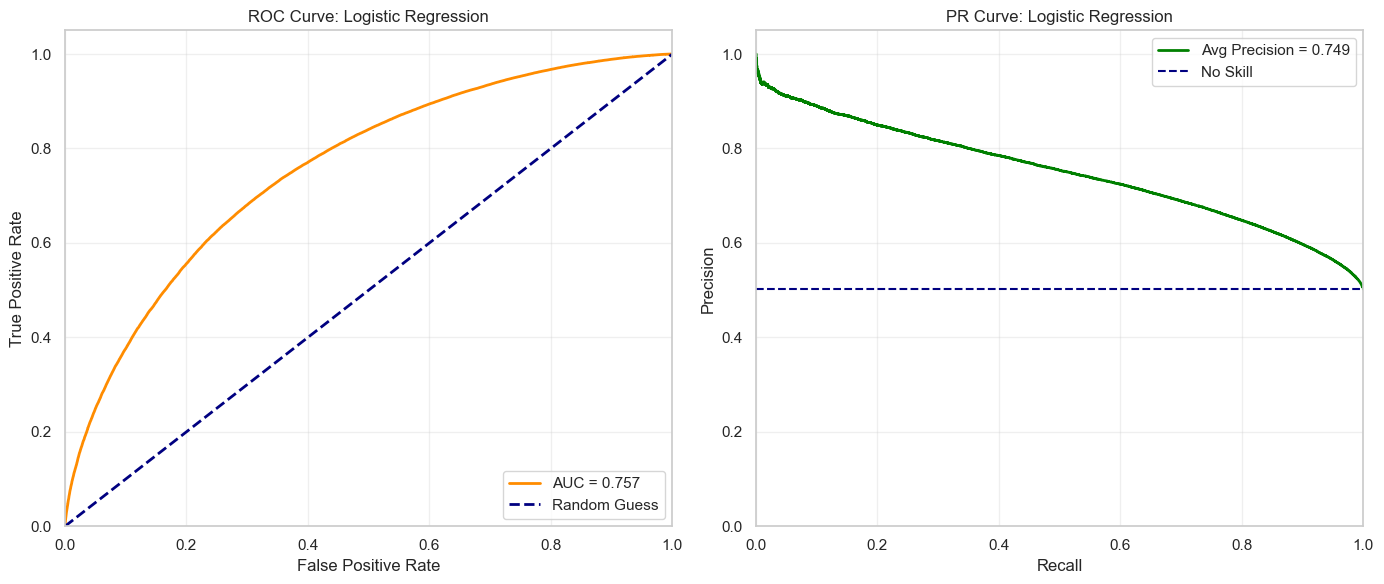

In [101]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=5000)
results_clf.append(
    evaluate_and_graph_clf(lr, X_train_full, y_train, X_test_full, y_test, "Logistic Regression", True)
)

## Generative Models (LDA and QDA)

--- LDA ---
Train Accuracy: 0.6905 | Train AUC: 0.7584
Test  Accuracy: 0.6906 | Test  AUC: 0.7575
✅ Model seems balanced
------------------------------


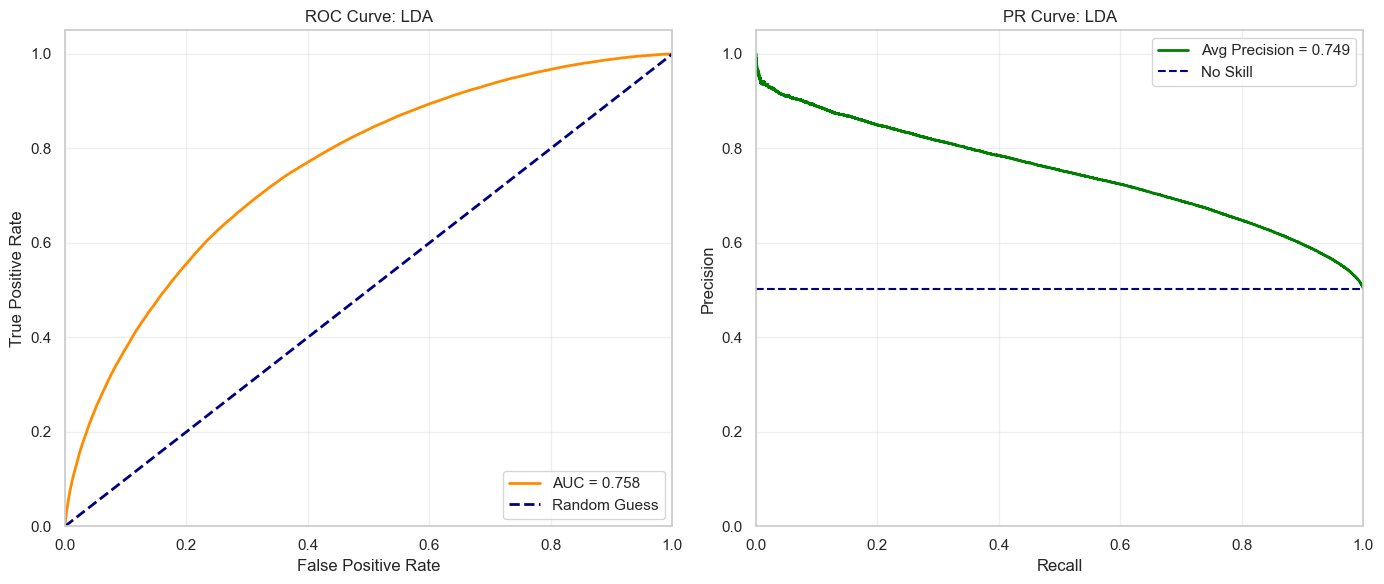

In [102]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
results_clf.append(
    evaluate_and_graph_clf(lda, X_train_full, y_train, X_test_full, y_test, "LDA", True)
)

--- QDA ---
Train Accuracy: 0.6852 | Train AUC: 0.7496
Test  Accuracy: 0.6854 | Test  AUC: 0.7491
✅ Model seems balanced
------------------------------


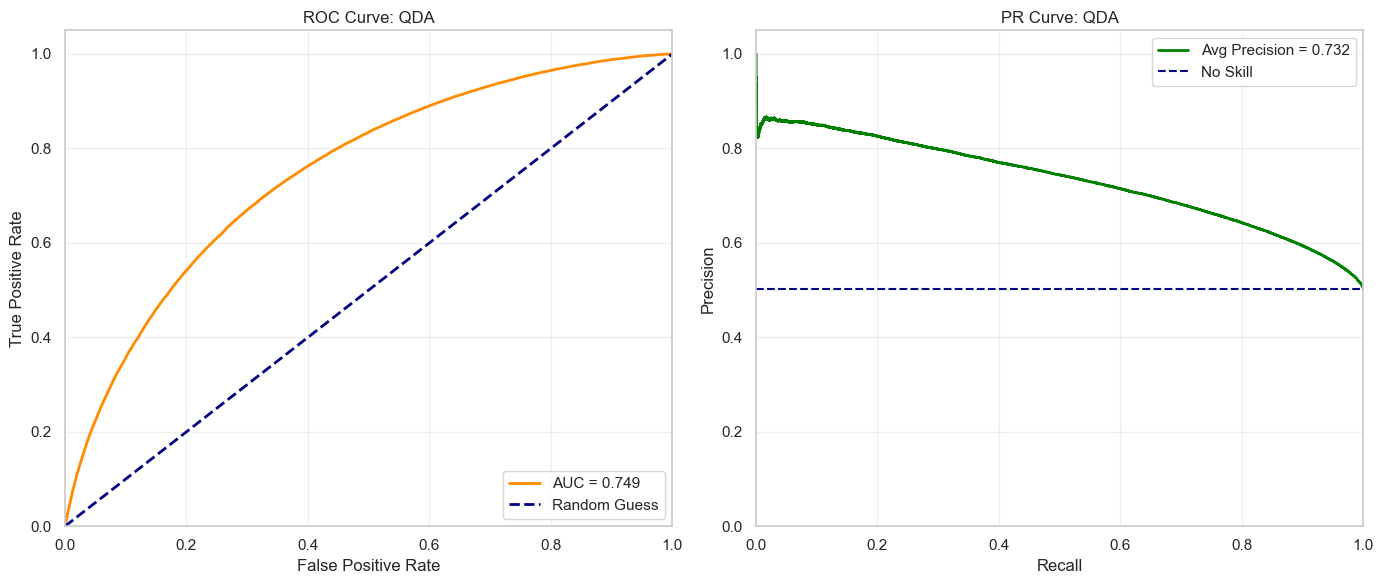

In [103]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis(reg_param=0.1)
results_clf.append(
    evaluate_and_graph_clf(qda, X_train_full, y_train, X_test_full, y_test, "QDA", True)
)

## Classification Tree

--- Decision Tree (Gini) ---
Train Accuracy: 0.6957 | Train AUC: 0.7646
Test  Accuracy: 0.6859 | Test  AUC: 0.7506
✅ Model seems balanced
------------------------------


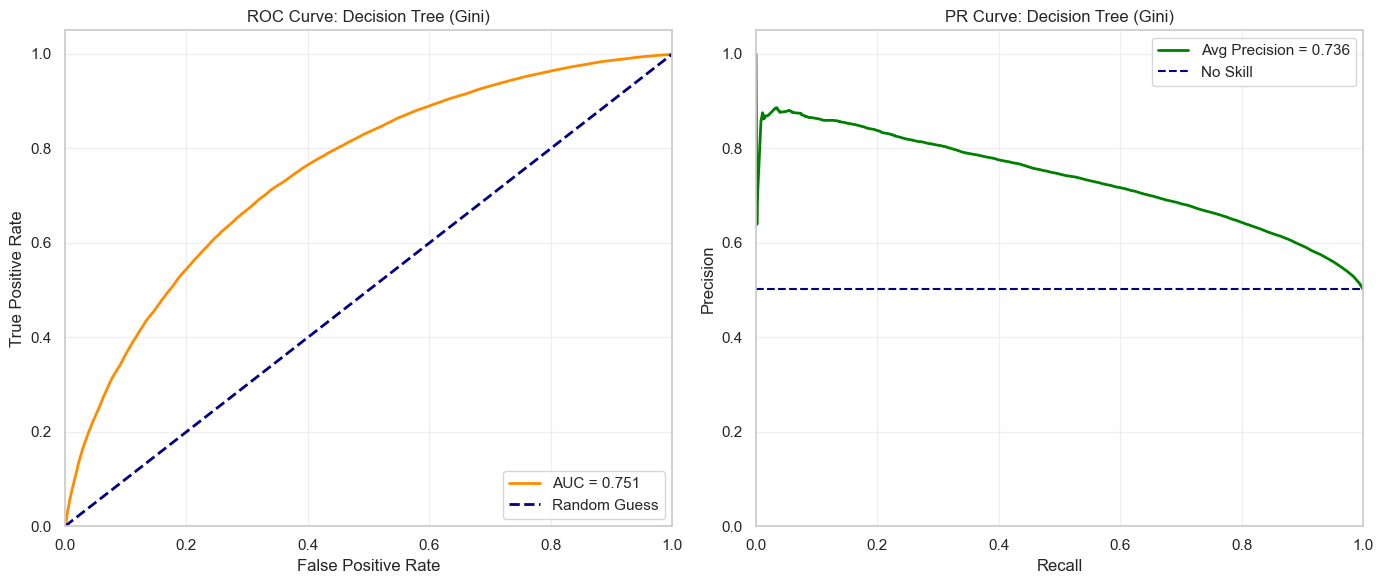

--- Decision Tree (Entropy) ---
Train Accuracy: 0.6940 | Train AUC: 0.7637
Test  Accuracy: 0.6871 | Test  AUC: 0.7513
✅ Model seems balanced
------------------------------


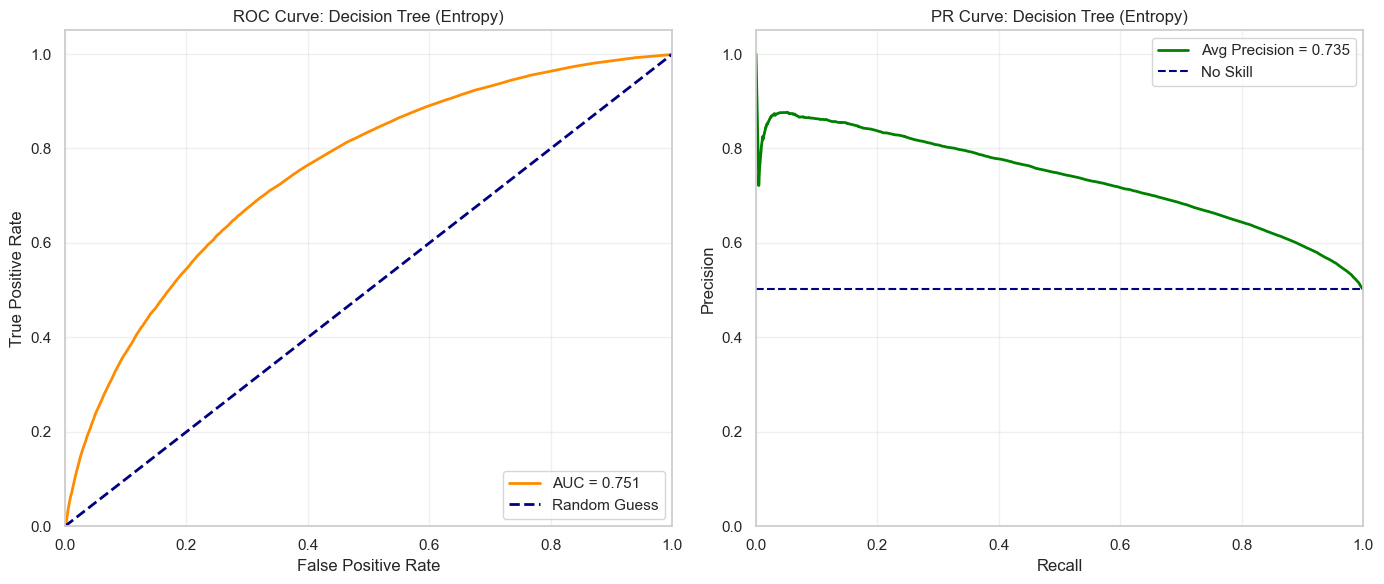

In [104]:
from sklearn.tree import DecisionTreeClassifier

dt_gini = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=SEED)
results_clf.append(
    evaluate_and_graph_clf(dt_gini, X_train_full, y_train, X_test_full, y_test, "Decision Tree (Gini)", True)
)

dt_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=SEED)
results_clf.append(
    evaluate_and_graph_clf(dt_entropy, X_train_full, y_train, X_test_full, y_test, "Decision Tree (Entropy)", True)
)

## Ensemble Methods (Bagging, Random Forest, Gradient Boosting)

--- Bagging (Trees) ---
Train Accuracy: 0.9998 | Train AUC: 1.0000
Test  Accuracy: 0.6681 | Test  AUC: 0.7290
⚠️ Warning: Signs of Overfitting (Train is much better than Test)
------------------------------


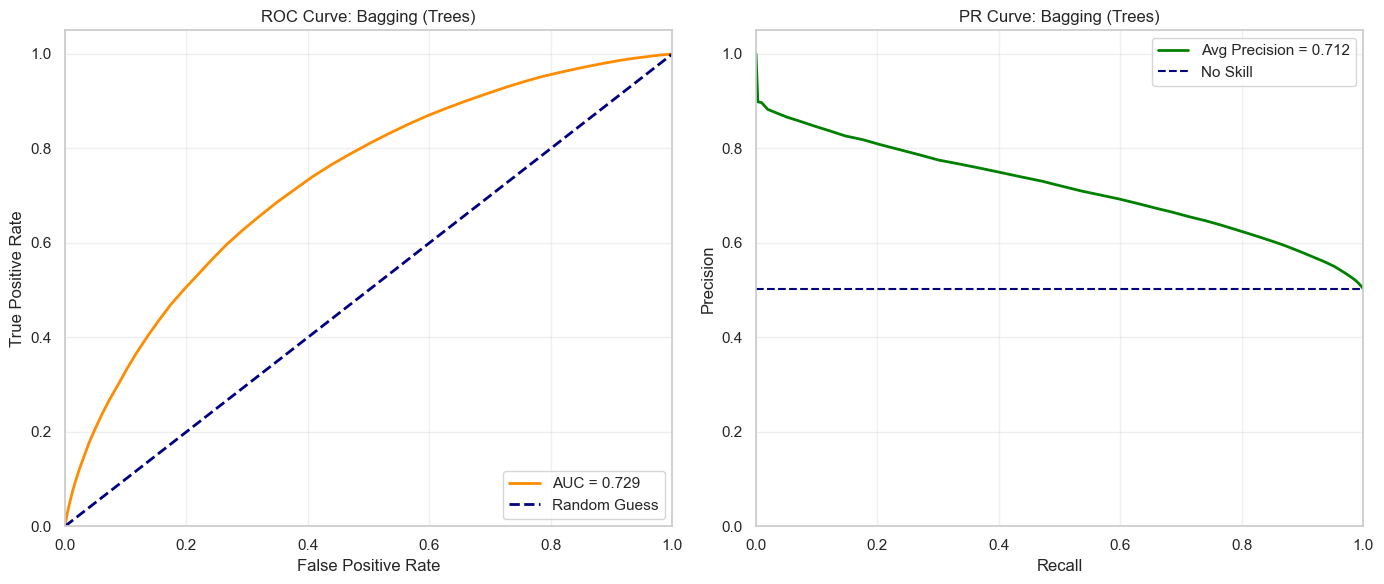

In [105]:
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(n_estimators=50, random_state=SEED)
results_clf.append(
    evaluate_and_graph_clf(bagging, X_train_full, y_train, X_test_full, y_test, "Bagging (Trees)", True)
)

--- Random Forest ---
Train Accuracy: 0.6964 | Train AUC: 0.7662
Test  Accuracy: 0.6897 | Test  AUC: 0.7556
✅ Model seems balanced
------------------------------


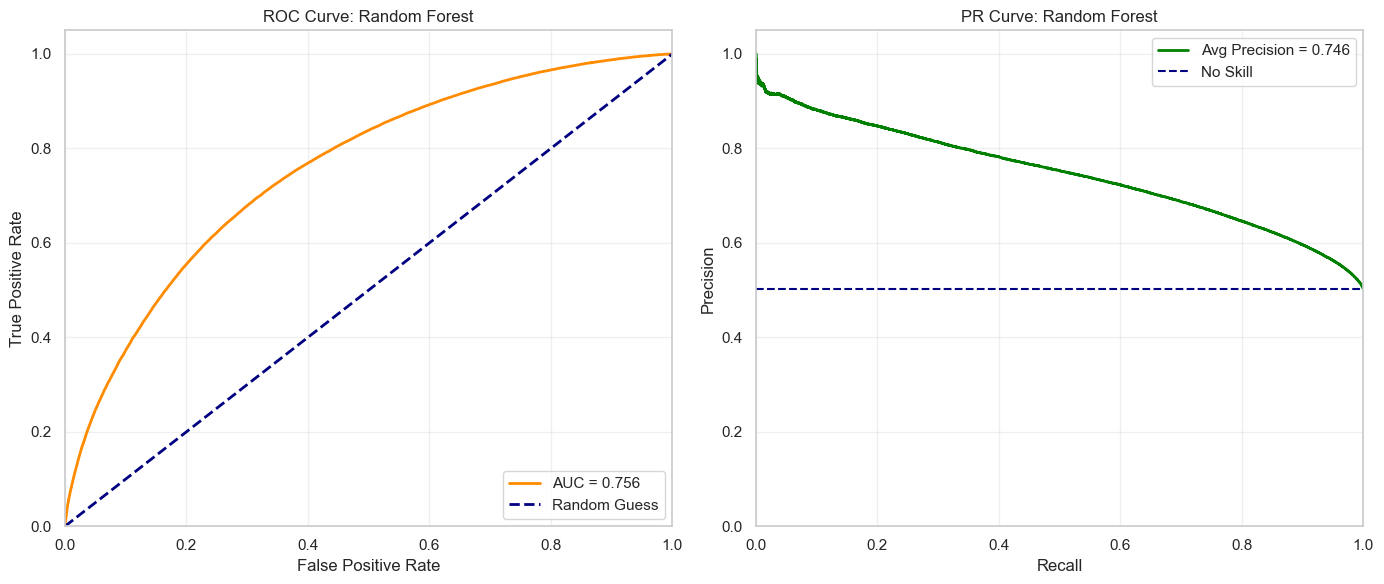

In [106]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=SEED)
results_clf.append(
    evaluate_and_graph_clf(rf, X_train_full, y_train, X_test_full, y_test, "Random Forest", True)
)

--- Gradient Boosting ---
Train Accuracy: 0.6911 | Train AUC: 0.7592
Test  Accuracy: 0.6904 | Test  AUC: 0.7570
✅ Model seems balanced
------------------------------


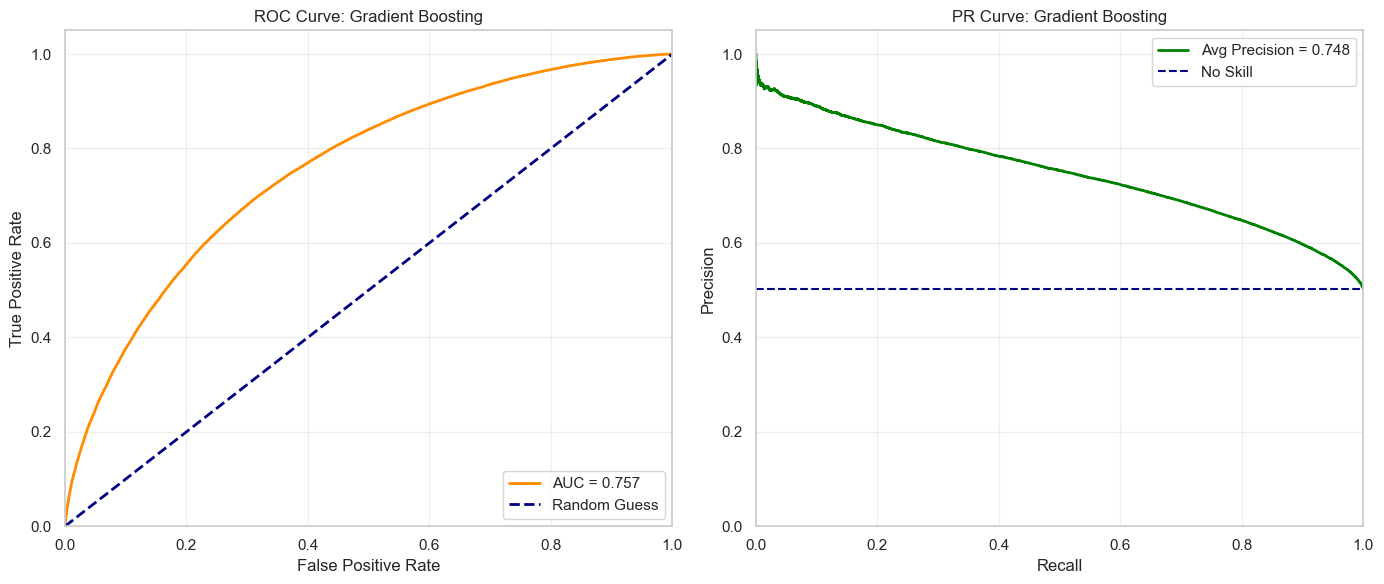

In [107]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=SEED)
results_clf.append(
    evaluate_and_graph_clf(gb, X_train_full, y_train, X_test_full, y_test, "Gradient Boosting", True)
)

# Results Classification

In [108]:
df_clf = pd.DataFrame(results_clf)
pick_best_model_clf(df_clf, overfit_threshold=0.05)

Total Models: 11
Valid Models: 9
Disqualified Models: 2

⚠️ The following models were disqualified due to overfitting:


model  accuracy       auc  train_auc  overfitting_gap
2       KNN (k=11)  0.663187  0.717353   0.799122         0.081769
8  Bagging (Trees)  0.668093  0.729013   1.000000         0.270987

Best by Accuracy:


model  accuracy       auc  average_precision  train_accuracy  train_auc  \
4   LDA  0.690591  0.757502           0.748716        0.690476   0.758419   

   overfitting_gap  is_overfit  
4         0.000917       False

Best by AUC:


model  accuracy       auc  average_precision  train_accuracy  train_auc  \
4   LDA  0.690591  0.757502           0.748716        0.690476   0.758419   

   overfitting_gap  is_overfit  
4         0.000917       False

Best by Average Precision:


model  accuracy       auc  average_precision  train_accuracy  train_auc  \
4   LDA  0.690591  0.757502           0.748716        0.690476   0.758419   

   overfitting_gap  is_overfit  
4         0.000917       False


Final ranking (higher = better):


model  accuracy       auc  average_precision  \
4                       LDA  0.690591  0.757502           0.748716   
3       Logistic Regression  0.690573  0.757494           0.748708   
10        Gradient Boosting  0.690373  0.756977           0.747950   
9             Random Forest  0.689747  0.755559           0.745899   
7   Decision Tree (Entropy)  0.687080  0.751251           0.735243   
6      Decision Tree (Gini)  0.685889  0.750637           0.735818   
5                       QDA  0.685351  0.749103           0.731693   
0    Naive Bayes (Gaussian)  0.678364  0.742325           0.729766   
1   Naive Bayes (Bernoulli)  0.662987  0.717843           0.697839   

    overfitting_gap  
4          0.000917  
3          0.000931  
10         0.002223  
9          0.010671  
7          0.012463  
6          0.013995  
5          0.000535  
0         -0.000224  
1         -0.000221


🏆 Best model: LDA


'LDA'

Text(0.5, 1.0, 'Confusion Matrix for Best Model')

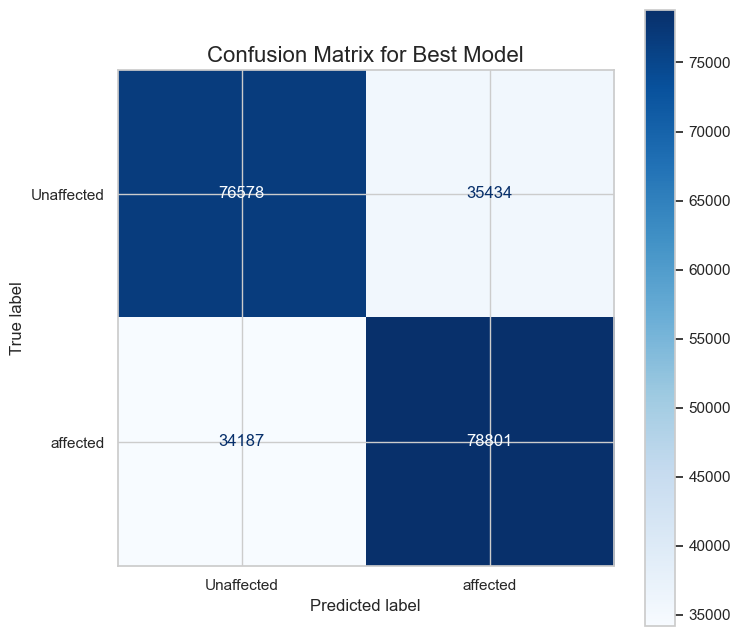

In [109]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_labels = ['Unaffected', 'affected']

y_pred = lr.predict(X_test_full)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_labels
)

disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)
plt.title('Confusion Matrix for Best Model', fontsize=16)

# Setup Quant Trait Regression

## Model Preparation

In [110]:
X = cohort[numeric_pcs_features + categorical_features]
y = cohort["quant_trait"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=SEED
)

X_train.shape, X_test.shape

((525000, 7), (225000, 7))

## Standardization

In [111]:
scaler = StandardScaler()

X_train_scaled_num = scaler.fit_transform(X_train[numeric_pcs_features])
X_train_scaled = pd.DataFrame(
    X_train_scaled_num,
    columns=numeric_pcs_features,
    index=X_train.index
)

X_test_scaled_num = scaler.transform(X_test[numeric_pcs_features])
X_test_scaled = pd.DataFrame(
    X_test_scaled_num,
    columns=numeric_pcs_features,
    index=X_test.index
)

X_train_scaled["sex"] = X_train["sex"].values
X_test_scaled["sex"] = X_test["sex"].values

X_train_scaled.head()

age  env_index  polygenic_score  quant_trait       PC1       PC2  \
6036   -0.206284  -1.470909         1.524975     1.187935 -1.272490  0.239766   
617631 -0.817624   2.181417         0.019218     0.191568  1.914633 -0.881347   
580701  0.405056  -1.188085        -0.352737     0.431638 -0.625959  0.442499   
696804 -1.225183   2.141173         0.173295     0.498567 -1.054864 -0.783709   
316225 -1.225183   1.805857         0.390879     0.669279  0.302336 -0.037086   

        sex  
6036      0  
617631    0  
580701    1  
696804    1  
316225    1

## Split Data Overview

In [112]:
# 1) Baseline: PRS only
features_baseline = ["polygenic_score"]

# 2) Full model: PRS + covariates (NO PCs)
features_full = ["age", "env_index", "polygenic_score", "sex"]

# 3) Full + PCA: PRS + covariates + PCs
features_full_pca = features_full + pcs_features

In [113]:
X_train_baseline = X_train_scaled[features_baseline]
X_test_baseline = X_test_scaled[features_baseline]

X_train_baseline.head(), X_train_baseline.mean(), X_train_baseline.std()

(        polygenic_score
 6036           1.524975
 617631         0.019218
 580701        -0.352737
 696804         0.173295
 316225         0.390879,
 polygenic_score   -2.982926e-17
 dtype: float64,
 polygenic_score    1.000001
 dtype: float64)

In [114]:
X_train_full = X_train_scaled[features_full]
X_test_full = X_test_scaled[features_full]

X_train_full.head(), X_train_full.mean(), X_train_full.std()

(             age  env_index  polygenic_score  sex
 6036   -0.206284  -1.470909         1.524975    0
 617631 -0.817624   2.181417         0.019218    0
 580701  0.405056  -1.188085        -0.352737    1
 696804 -1.225183   2.141173         0.173295    1
 316225 -1.225183   1.805857         0.390879    1,
 age               -1.188433e-16
 env_index         -2.202006e-17
 polygenic_score   -2.982926e-17
 sex                4.989829e-01
 dtype: float64,
 age                1.000001
 env_index          1.000001
 polygenic_score    1.000001
 sex                0.499999
 dtype: float64)

In [115]:
X_train_full_pca = X_train_scaled[features_full_pca]
X_test_full_pca  = X_test_scaled[features_full_pca]

X_train_full_pca.head(), X_train_full_pca.mean(), X_train_full_pca.std()

(             age  env_index  polygenic_score  sex       PC1       PC2
 6036   -0.206284  -1.470909         1.524975    0 -1.272490  0.239766
 617631 -0.817624   2.181417         0.019218    0  1.914633 -0.881347
 580701  0.405056  -1.188085        -0.352737    1 -0.625959  0.442499
 696804 -1.225183   2.141173         0.173295    1 -1.054864 -0.783709
 316225 -1.225183   1.805857         0.390879    1  0.302336 -0.037086,
 age               -1.188433e-16
 env_index         -2.202006e-17
 polygenic_score   -2.982926e-17
 sex                4.989829e-01
 PC1               -2.146854e-18
 PC2               -3.282031e-18
 dtype: float64,
 age                1.000001
 env_index          1.000001
 polygenic_score    1.000001
 sex                0.499999
 PC1                1.000001
 PC2                1.000001
 dtype: float64)

# Regression Models

Functions that will be used constantly for model evaluation

In [116]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_and_graph_reg(model, X_train, y_train, X_test, y_test, name, graph):
    model.fit(X_train, y_train)

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # --- Metrics (same as evaluate_and_graph_reg) ---
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    print(f"--- {name} ---")
    print(f"Train RMSE: {rmse_train:.4f} | Train R²: {r2_train:.4f}")
    print(f"Test  RMSE: {rmse_test:.4f} | Test  R²: {r2_test:.4f}")

    if (r2_train - r2_test) > 0.05:
        print("⚠️ Warning: Signs of Overfitting (Train R² much higher than Test R²)")
    else:
        print("✅ Model seems reasonably balanced")
    print("-" * 30)

    # --- Plots (equivalent to plot_full_diagnostics) ---
    if graph:
        residuals = y_test - y_pred_test
        r2 = r2_test

        fig, axs = plt.subplots(2, 2, figsize=(12, 10))

        # 1) Predicted vs True
        axs[0, 0].scatter(y_test, y_pred_test, alpha=0.5)
        slope, intercept = np.polyfit(y_test, y_pred_test, 1)
        axs[0, 0].plot(y_test, slope * y_test + intercept, color="blue", label="Regression Line")
        axs[0, 0].plot(
            [y_test.min(), y_test.max()],
            [y_test.min(), y_test.max()],
            color="red", linestyle="--", label="Identity Line"
        )
        axs[0, 0].set_xlabel("True Values")
        axs[0, 0].set_ylabel("Predicted Values")
        axs[0, 0].set_title(f"Predicted vs True ({name})\n$R^2 = {r2:.3f}$")
        axs[0, 0].legend()

        # 2) Residual Histogram
        sns.histplot(residuals, kde=True, bins=20, ax=axs[0, 1])
        axs[0, 1].set_title("Residual Distribution")
        axs[0, 1].set_xlabel("Residual")
        axs[0, 1].set_ylabel("Count")

        # 3) Residuals vs Fitted
        axs[1, 0].scatter(y_pred_test, residuals, alpha=0.5)
        axs[1, 0].axhline(0, color="red", linestyle="--")
        axs[1, 0].set_xlabel("Fitted Values")
        axs[1, 0].set_ylabel("Residuals")
        axs[1, 0].set_title("Residuals vs Fitted")

        # 4) QQ Plot
        stats.probplot(residuals, dist="norm", plot=axs[1, 1])
        axs[1, 1].set_title("QQ Plot")

        plt.tight_layout()
        plt.show()

    return {
        "model": name,
        "rmse_train": rmse_train,
        "rmse_test": rmse_test,
        "r2_train": r2_train,
        "r2_test": r2_test,
    }

def pick_best_model_reg(dataframe, overfit_threshold=0.05):
    if dataframe is None or dataframe.empty:
        print("No models provided (empty DataFrame).")
        return None

    df = dataframe.copy()

    # Overfitting criterion: big gap in R² between train and test
    df['overfitting_gap'] = df['r2_train'] - df['r2_test']
    df['is_overfit'] = df['overfitting_gap'] > overfit_threshold

    df_valid = df[~df['is_overfit']].copy()
    df_overfit = df[df['is_overfit']].copy()

    print(f"Total Models: {len(df)}")
    print(f"Valid Models: {len(df_valid)}")
    print(f"Disqualified Models: {len(df_overfit)}")

    if not df_overfit.empty:
        print("\n⚠️ Disqualified for overfitting:")
        display(df_overfit[['model', 'r2_test', 'rmse_test', 'r2_train', 'overfitting_gap']])
    else:
        print("\n✅ No models were disqualified for overfitting.")

    if df_valid.empty:
        print("\n⚠️ All models flagged as overfitting; ranking ALL models by R².")
        df_valid = df.copy()

    print("Best by R² (Test Set):")
    display(df_valid.sort_values(by="r2_test", ascending=False).head(1))

    print("Best by RMSE (Test Set):")
    display(df_valid.sort_values(by="rmse_test", ascending=True).head(1))

    # print("Best by MAE:")
    # display(df_valid.sort_values(by="mae", ascending=True).head(1))

    df_valid_ranked = df_valid.copy()
    df_valid_ranked["rank_r2"] = df_valid_ranked["r2_test"].rank(ascending=False)
    df_valid_ranked["rank_rmse"] = df_valid_ranked["rmse_test"].rank(ascending=True)
    # df_valid_ranked["rank_mae"] = df_valid_ranked["mae"].rank(ascending=True)

    final_ranking = df_valid_ranked.sort_values(
        by=["rank_r2", "rank_rmse"] #, "rank_mae"]
    )

    # cols = ['model', 'r2', 'rmse', 'mae', 'overfitting_gap']
    cols = ['model', 'r2_test', 'rmse_test', 'overfitting_gap']
    print("\nFinal ranking (better at top):")
    display(final_ranking[cols])

    best_model_row = final_ranking.iloc[0]
    best_model_name = best_model_row['model']
    print(f"\n🏆 Best regression model: {best_model_name}")

    return best_model_name

## Linear Regression

--- LR Baseline (PRS only) ---
Train RMSE: 0.7481 | Train R²: 0.4393
Test  RMSE: 0.7515 | Test  R²: 0.4376
✅ Model seems reasonably balanced
------------------------------


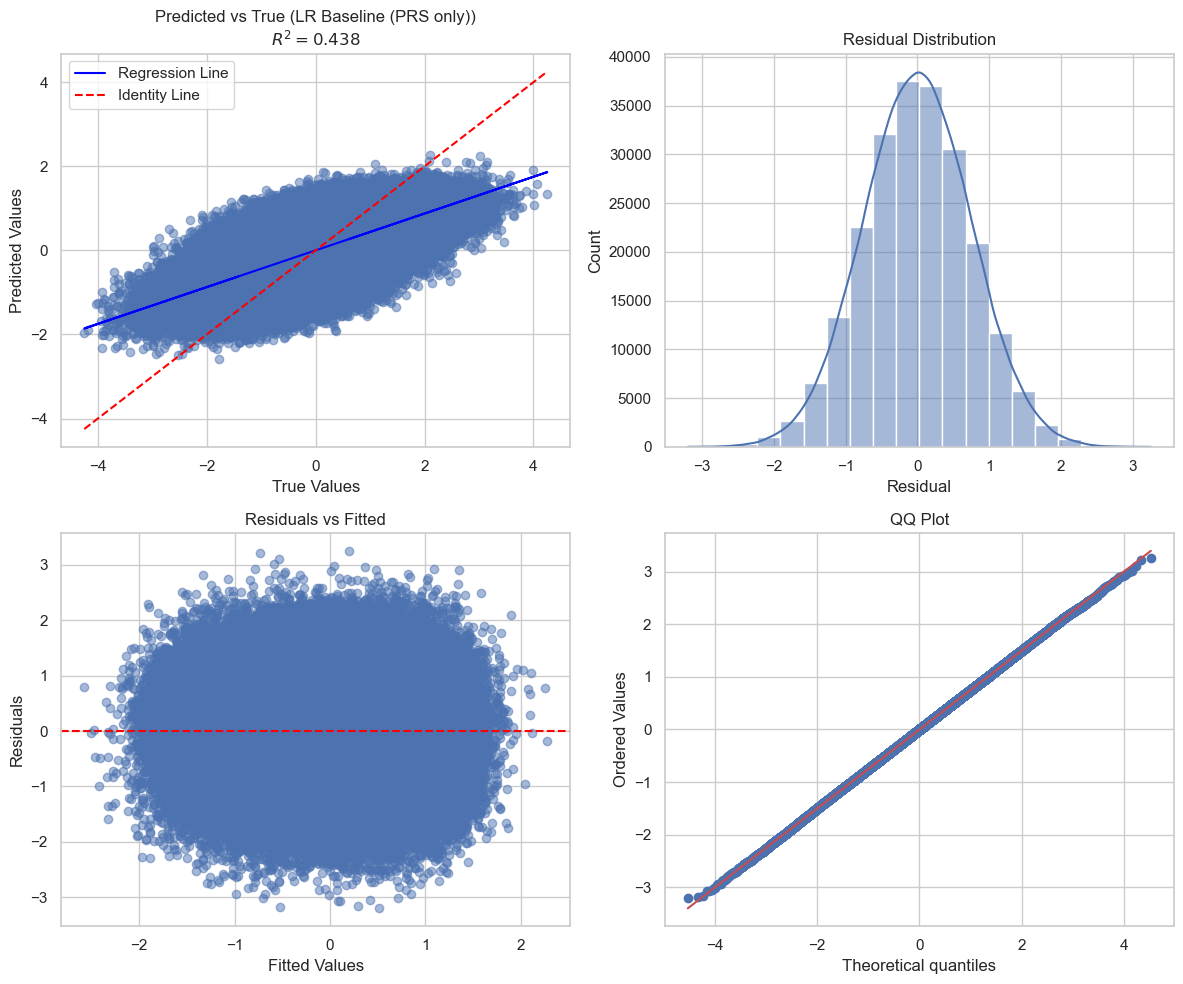

--- LR Full (PRS + covariates) ---
Train RMSE: 0.6636 | Train R²: 0.5588
Test  RMSE: 0.6653 | Test  R²: 0.5593
✅ Model seems reasonably balanced
------------------------------


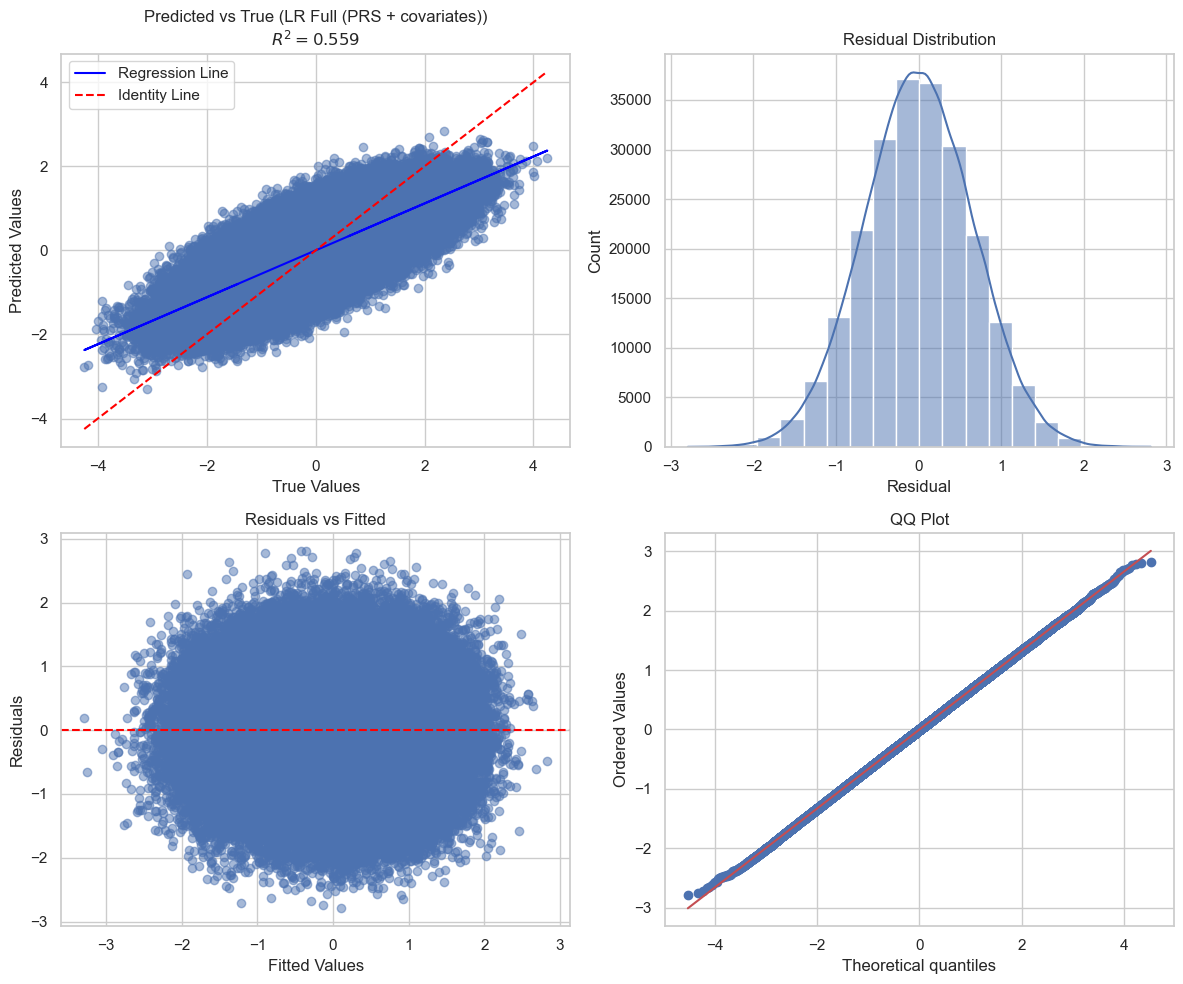

--- LR Full + PCA ---
Train RMSE: 0.6636 | Train R²: 0.5588
Test  RMSE: 0.6653 | Test  R²: 0.5593
✅ Model seems reasonably balanced
------------------------------


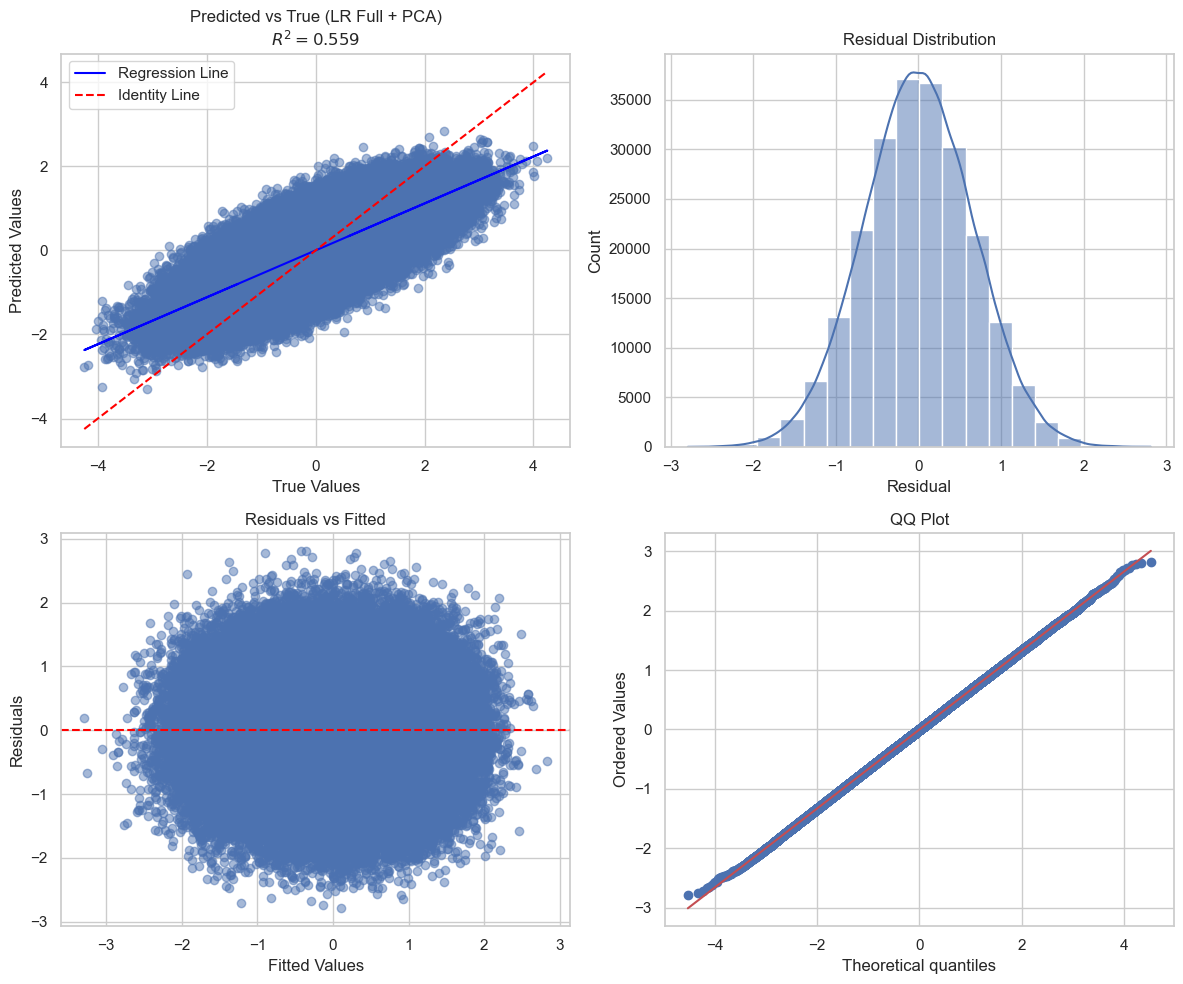

In [117]:
from sklearn.linear_model import LinearRegression

results_reg = []

# 1. Baseline: PRS only
lr_baseline = LinearRegression()
results_reg.append(
    evaluate_and_graph_reg(lr_baseline, X_train_baseline, y_train, X_test_baseline, y_test, "LR Baseline (PRS only)", True)
)

# 2. Full model
lr_full = LinearRegression()
results_reg.append(
    evaluate_and_graph_reg(lr_full, X_train_full, y_train, X_test_full, y_test, "LR Full (PRS + covariates)", True)
)

# 3. Full + PCA
lr_full_pca = LinearRegression()
results_reg.append(
    evaluate_and_graph_reg(lr_full_pca, X_train_full_pca, y_train, X_test_full_pca, y_test, "LR Full + PCA", True)
)

## Subset Selection

--- RFE Subset Selection (Full, 4 feats) ---
Train RMSE: 0.6636 | Train R²: 0.5588
Test  RMSE: 0.6653 | Test  R²: 0.5593
✅ Model seems reasonably balanced
------------------------------


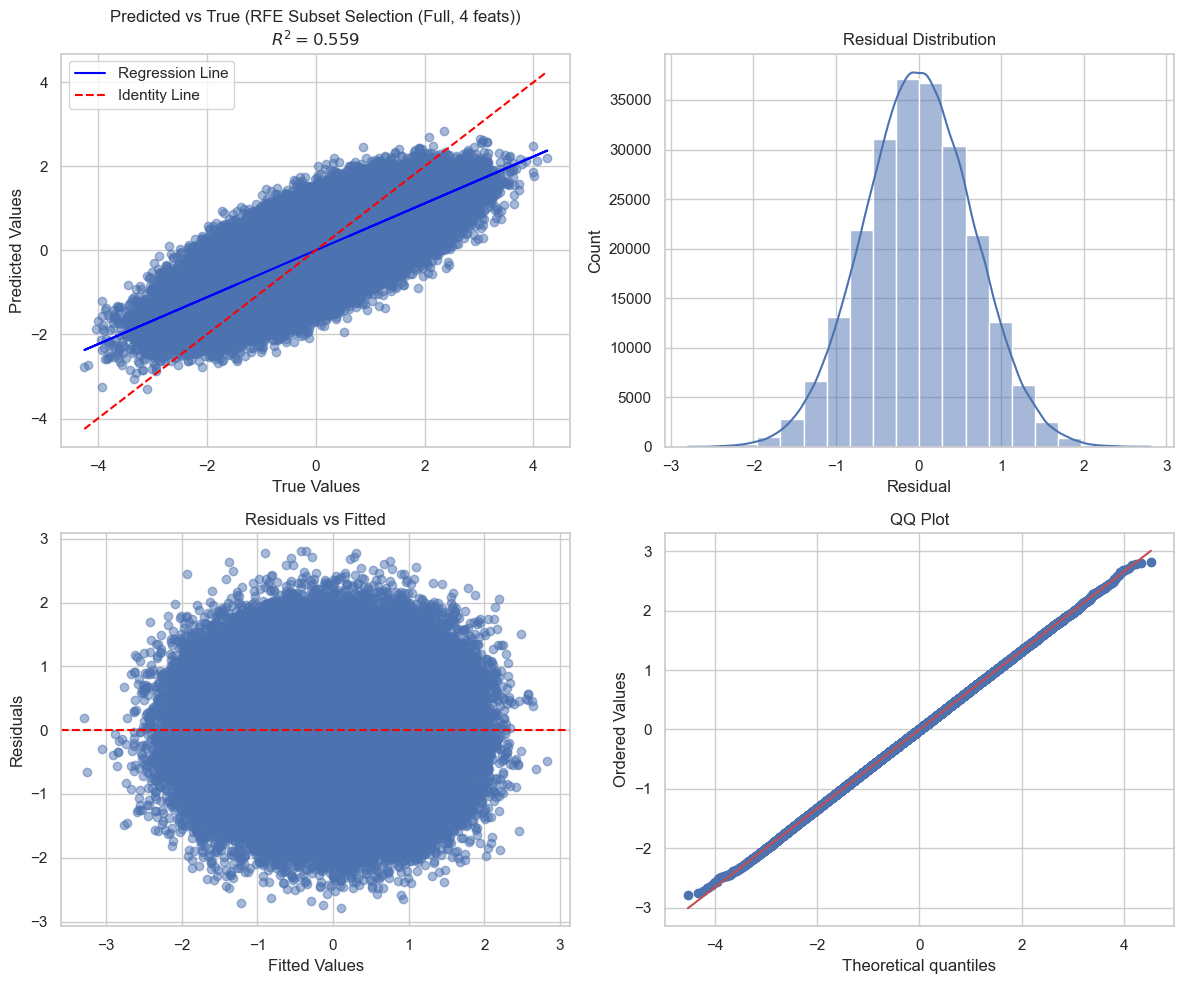

--- RFE Subset (Full + PCA, selected 4 components) ---
Train RMSE: 0.7910 | Train R²: 0.3731
Test  RMSE: 0.7928 | Test  R²: 0.3742
✅ Model seems reasonably balanced
------------------------------


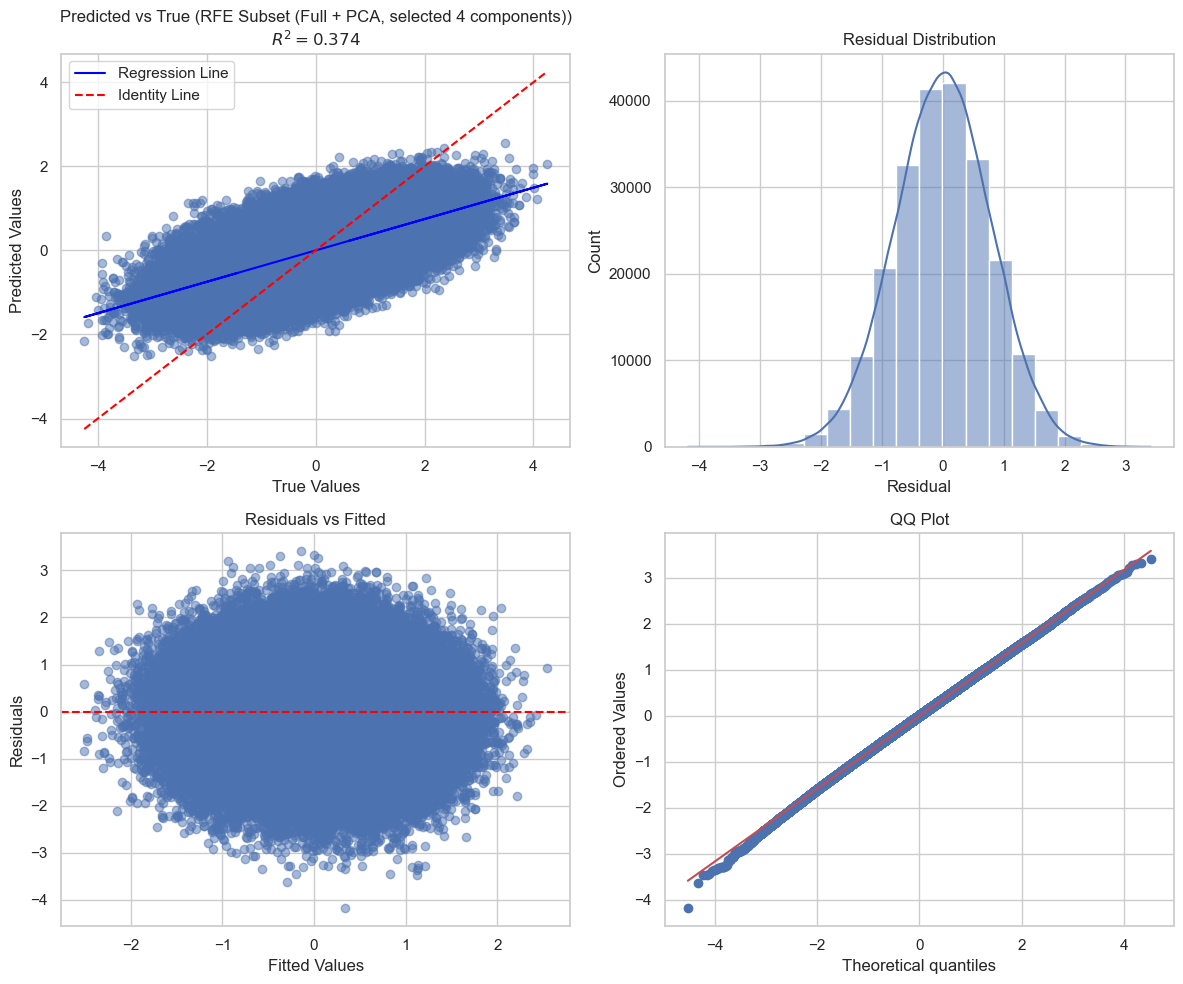

In [118]:
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# --- Configuration ---
base_estimator = LinearRegression()
features_to_select = 4

# --- 1. RFE on Full Features ---
rfe_full = RFE(
    estimator=base_estimator,
    n_features_to_select=features_to_select
)

results_reg.append(
    evaluate_and_graph_reg(rfe_full, X_train_full, y_train, X_test_full, y_test, f"RFE Subset Selection (Full, {features_to_select} feats)", True)
)

# # --- 2. RFE on Full + PCA Features ---
pca_components = 4
rfe_pca_select = 4

rfe_full_pca = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=pca_components)),
    ('rfe', RFE(
        estimator=base_estimator,
        n_features_to_select=rfe_pca_select
    ))
])

results_reg.append(
    evaluate_and_graph_reg(rfe_full_pca, X_train_full_pca, y_train, X_test_full_pca, y_test, f"RFE Subset (Full + PCA, selected {rfe_pca_select} components)", True)
)

## Shrinkage Methods (Ridge, Lasso, Elastic Net)

--- Ridge (alpha=4.1987) ---
Train RMSE: 0.6636 | Train R²: 0.5588
Test  RMSE: 0.6653 | Test  R²: 0.5593
✅ Model seems reasonably balanced
------------------------------


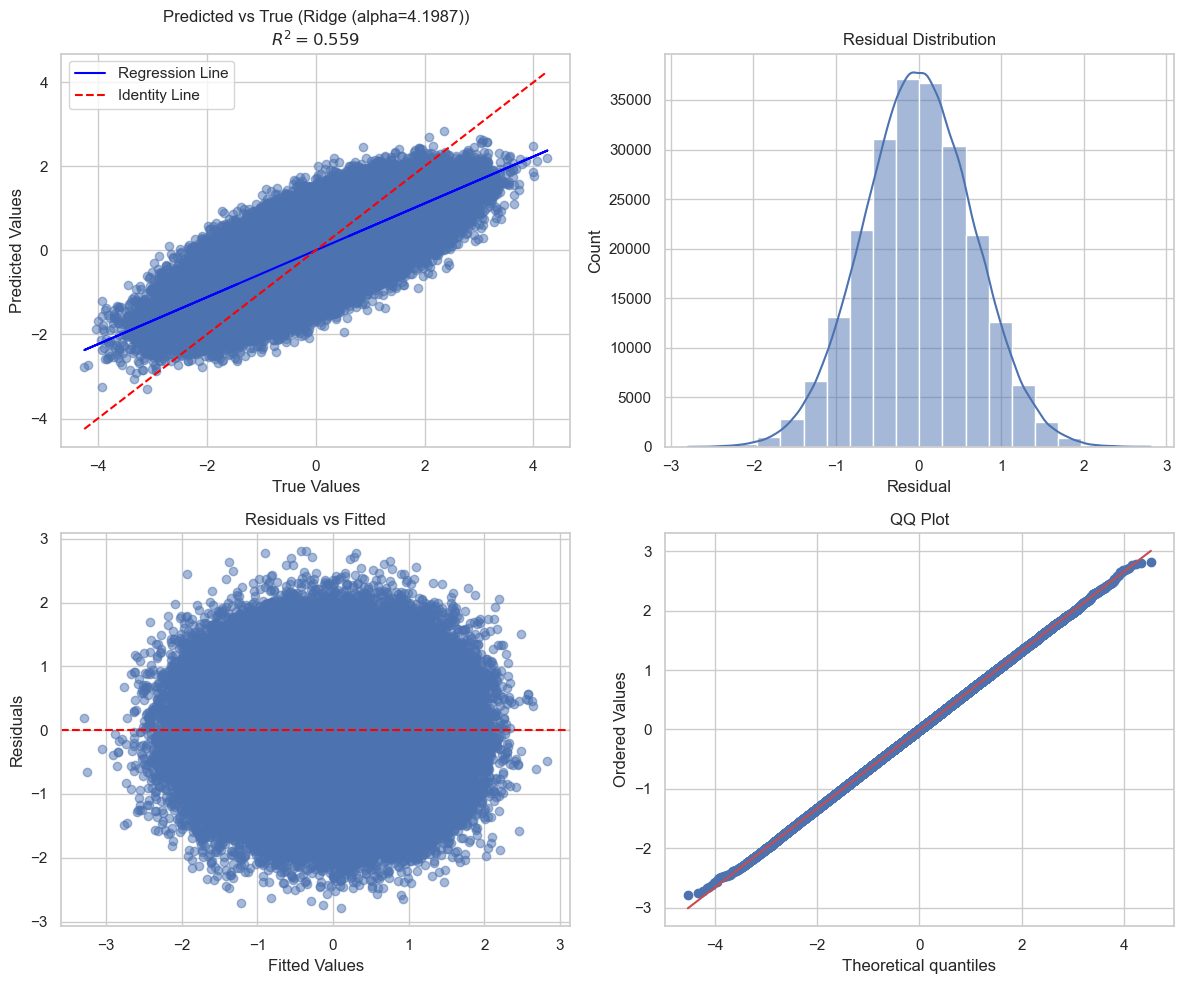

In [119]:
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-4, 4, 200)

ridge_cv = RidgeCV(alphas=alphas)
ridge_cv.fit(X_train_full, y_train)

ridge_alpha = ridge_cv.alpha_

results_ridge = evaluate_and_graph_reg(ridge_cv, X_train_full, y_train, X_test_full, y_test, f"Ridge (alpha={ridge_alpha:.4f})", True)
results_reg.append(results_ridge)

--- Lasso (alpha=0.0007) ---
Train RMSE: 0.6636 | Train R²: 0.5588
Test  RMSE: 0.6653 | Test  R²: 0.5592
✅ Model seems reasonably balanced
------------------------------


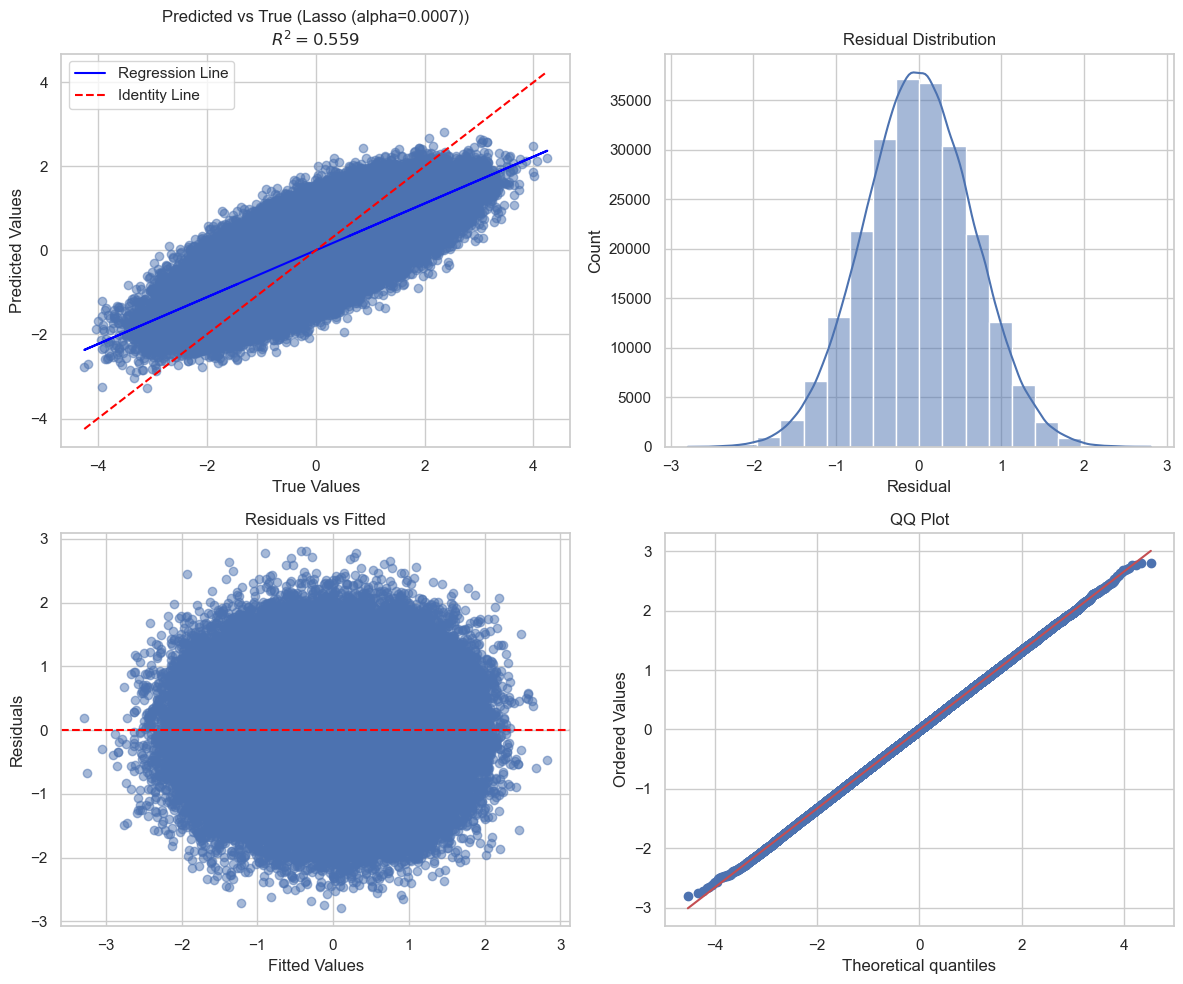

In [120]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(
    cv=10,
    max_iter=5000,
    random_state=SEED
)
lasso_cv.fit(X_train_full, y_train)

lasso_alpha = lasso_cv.alpha_

results_lasso = evaluate_and_graph_reg(lasso_cv, X_train_full, y_train, X_test_full, y_test, f"Lasso (alpha={lasso_alpha:.4f})", True)
results_reg.append(results_lasso)

--- ElasticNet (alpha=0.0007, l1_ratio=0.99) ---
Train RMSE: 0.6636 | Train R²: 0.5588
Test  RMSE: 0.6653 | Test  R²: 0.5592
✅ Model seems reasonably balanced
------------------------------


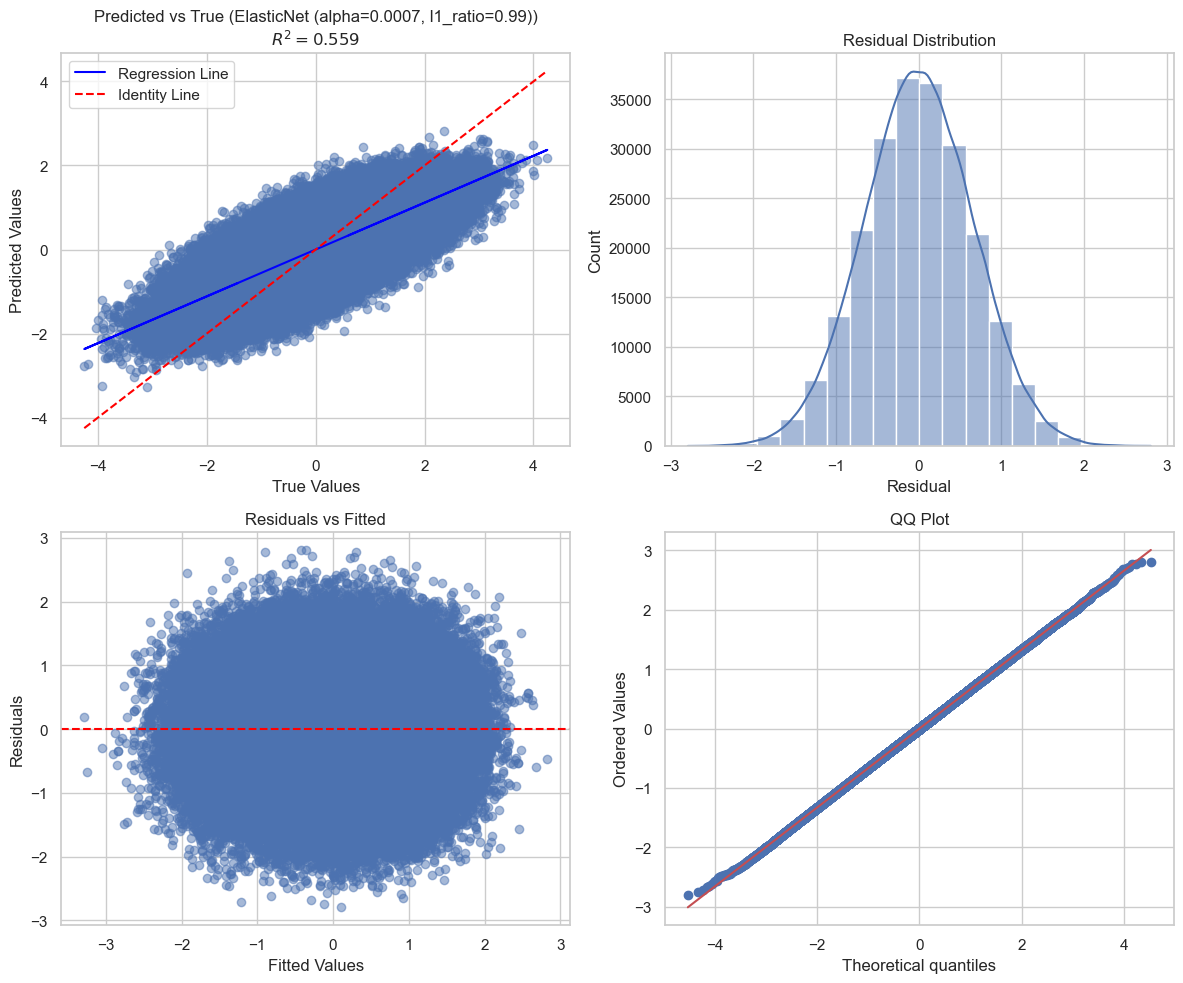

In [121]:
from sklearn.linear_model import ElasticNetCV

elastic_cv = ElasticNetCV(
    l1_ratio=np.linspace(0.01, 0.99, 20),
    cv=10,
    max_iter=5000,
    random_state=SEED
)
elastic_cv.fit(X_train_full, y_train)

elastic_alpha = elastic_cv.alpha_
elastic_l1 = elastic_cv.l1_ratio_

results_elastic = evaluate_and_graph_reg(elastic_cv, X_train_full, y_train, X_test_full, y_test, f"ElasticNet (alpha={elastic_alpha:.4f}, l1_ratio={elastic_l1:.2f})", True)
results_reg.append(results_elastic)

In [122]:
shrinkage_df = pd.DataFrame([
    results_ridge,
    results_lasso,
    results_elastic
])
shrinkage_df

model  rmse_train  rmse_test  r2_train  \
0                      Ridge (alpha=4.1987)    0.663641   0.665296  0.558776   
1                      Lasso (alpha=0.0007)    0.663643   0.665302  0.558773   
2  ElasticNet (alpha=0.0007, l1_ratio=0.99)    0.663643   0.665302  0.558773   

    r2_test  
0  0.559251  
1  0.559243  
2  0.559243

In [123]:
coef_df = pd.DataFrame({
    "OLS": lr_full.coef_,
    "Ridge": ridge_cv.coef_,
    "Lasso": lasso_cv.coef_,
    "ElasticNet": elastic_cv.coef_
}, index=X_train_full.columns)
coef_df

OLS     Ridge     Lasso  ElasticNet
age              0.010941  0.010941  0.010277    0.010277
env_index        0.330613  0.330611  0.329949    0.329947
polygenic_score  0.662411  0.662405  0.661748    0.661743
sex              0.199064  0.199058  0.196414    0.196408

<Figure size 1000x600 with 0 Axes>

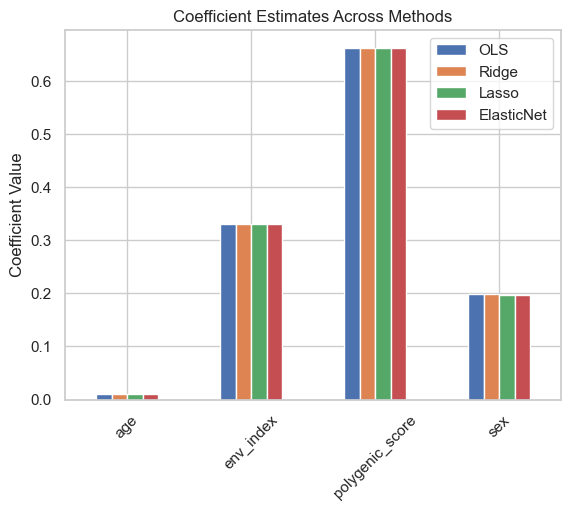

In [124]:
plt.figure(figsize=(10,6))
coef_df.plot(kind="bar")
plt.title("Coefficient Estimates Across Methods")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45)
plt.show()

## Regression Tree

--- Regression Tree (PRS only) ---
Train RMSE: 0.7459 | Train R²: 0.4426
Test  RMSE: 0.7537 | Test  R²: 0.4343
✅ Model seems reasonably balanced
------------------------------


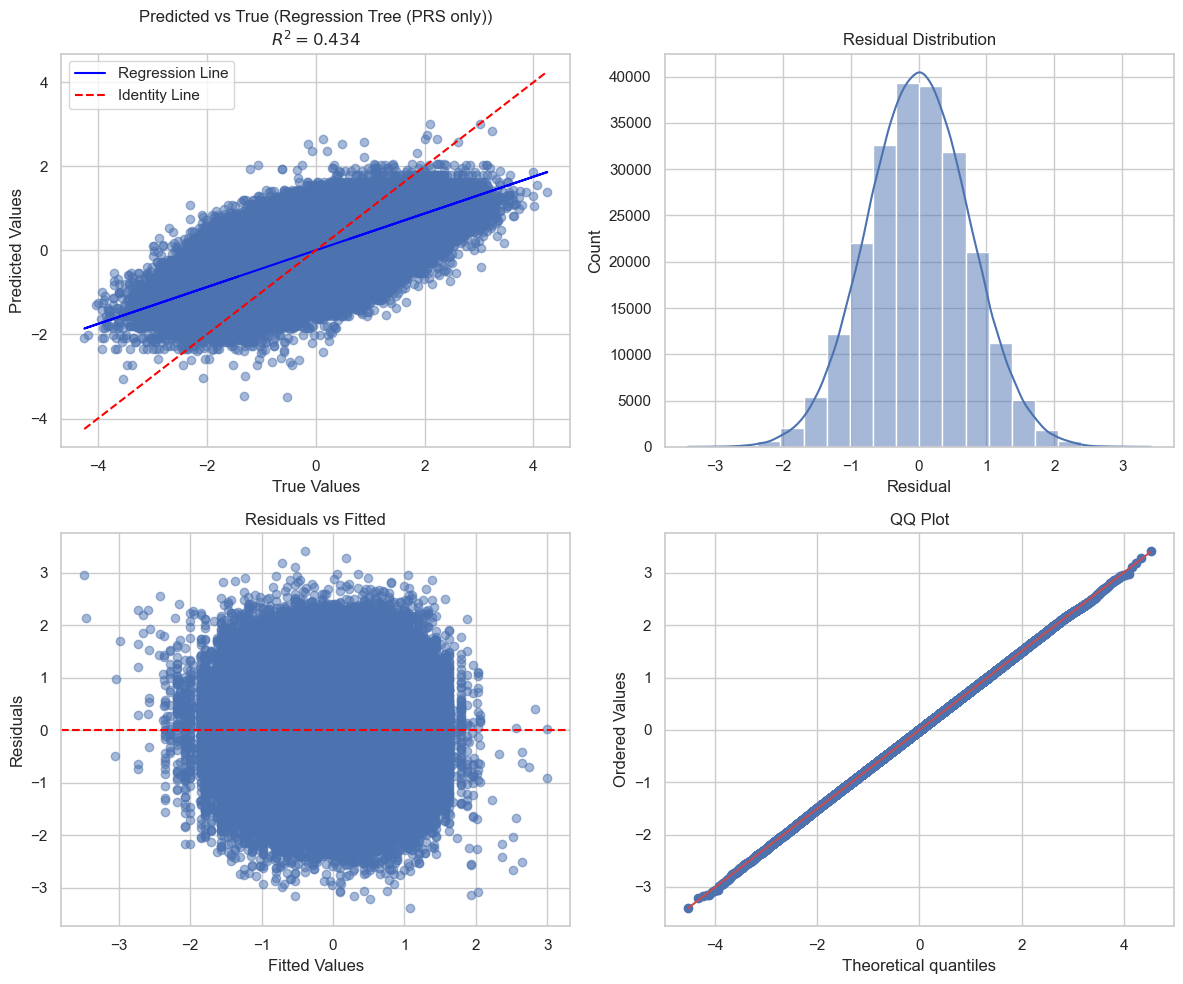

--- Regression Tree (PRS + covariates) ---
Train RMSE: 0.6604 | Train R²: 0.5630
Test  RMSE: 0.6704 | Test  R²: 0.5525
✅ Model seems reasonably balanced
------------------------------


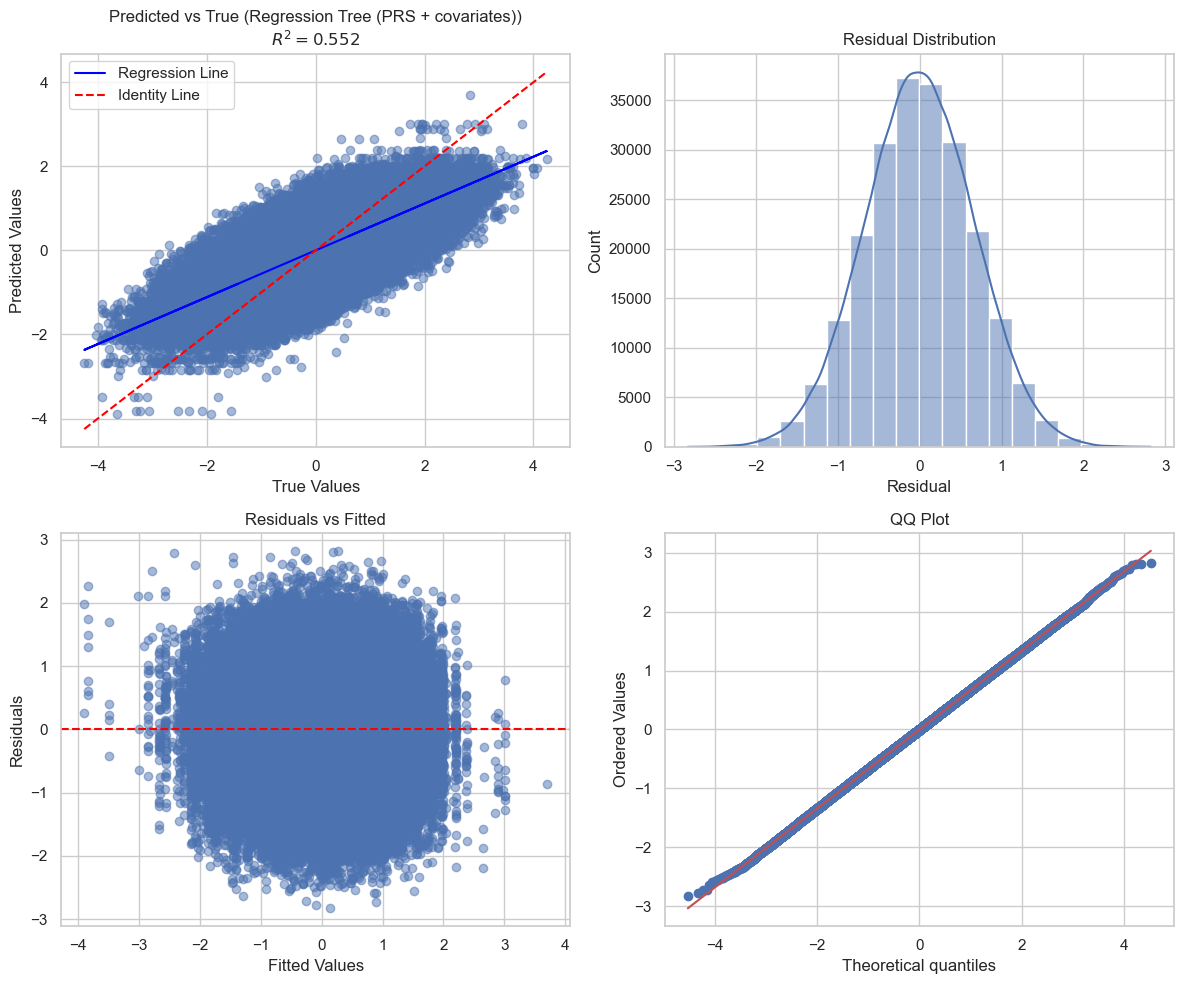

--- Regression Tree + PCA ---
Train RMSE: 0.6602 | Train R²: 0.5633
Test  RMSE: 0.6709 | Test  R²: 0.5518
✅ Model seems reasonably balanced
------------------------------


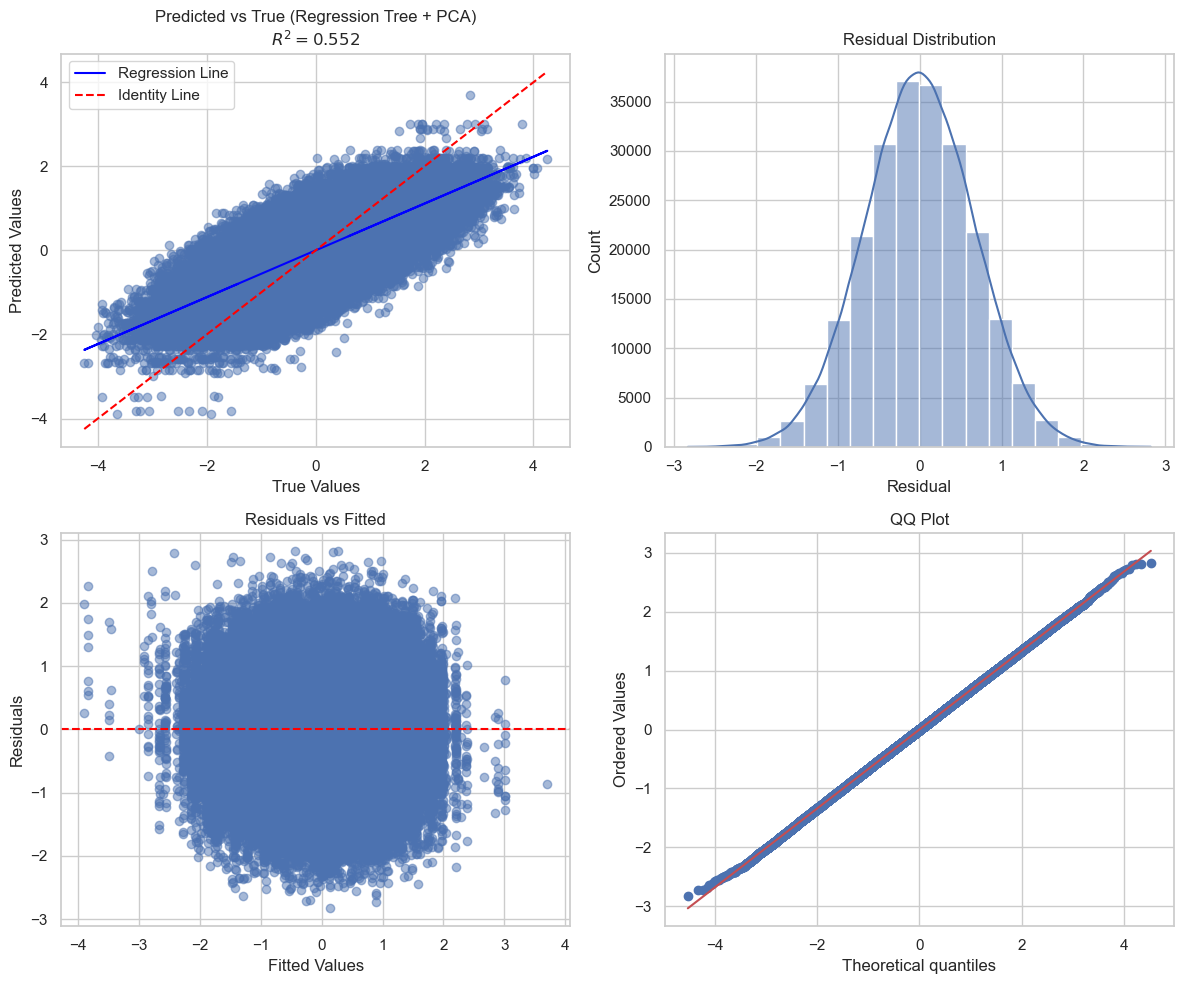

In [125]:
from sklearn.tree import DecisionTreeRegressor

# 1. Baseline: PRS only
reg_baseline = DecisionTreeRegressor(random_state=SEED, max_depth=10)
results_reg.append(
    evaluate_and_graph_reg(reg_baseline, X_train_baseline, y_train, X_test_baseline, y_test, "Regression Tree (PRS only)", True)
)

# 2. Full model
reg_full = DecisionTreeRegressor(random_state=SEED, max_depth=10)
results_reg.append(
    evaluate_and_graph_reg(reg_full, X_train_full, y_train, X_test_full, y_test, "Regression Tree (PRS + covariates)", True)
)

# 3. Full + PCA
reg_full_pca = DecisionTreeRegressor(random_state=SEED, max_depth=10)
results_reg.append(
    evaluate_and_graph_reg(reg_full_pca, X_train_full_pca, y_train, X_test_full_pca, y_test, "Regression Tree + PCA", True)
)

# Results Regression

In [126]:
df_reg = pd.DataFrame(results_reg)
pick_best_model_reg(df_reg, overfit_threshold=0.05)

Total Models: 11
Valid Models: 11
Disqualified Models: 0

✅ No models were disqualified for overfitting.
Best by R² (Test Set):


model  rmse_train  rmse_test  r2_train   r2_test  overfitting_gap  \
2  LR Full + PCA     0.66364   0.665294  0.558778  0.559253        -0.000475   

   is_overfit  
2       False

Best by RMSE (Test Set):


model  rmse_train  rmse_test  r2_train   r2_test  overfitting_gap  \
2  LR Full + PCA     0.66364   0.665294  0.558778  0.559253        -0.000475   

   is_overfit  
2       False


Final ranking (better at top):


model   r2_test  rmse_test  \
2                                    LR Full + PCA  0.559253   0.665294   
1                       LR Full (PRS + covariates)  0.559251   0.665296   
3             RFE Subset Selection (Full, 4 feats)  0.559251   0.665296   
5                             Ridge (alpha=4.1987)  0.559251   0.665296   
6                             Lasso (alpha=0.0007)  0.559243   0.665302   
7         ElasticNet (alpha=0.0007, l1_ratio=0.99)  0.559243   0.665302   
9               Regression Tree (PRS + covariates)  0.552498   0.670374   
10                           Regression Tree + PCA  0.551783   0.670909   
0                           LR Baseline (PRS only)  0.437629   0.751503   
8                       Regression Tree (PRS only)  0.434330   0.753704   
4   RFE Subset (Full + PCA, selected 4 components)  0.374175   0.792768   

    overfitting_gap  
2         -0.000475  
1         -0.000475  
3         -0.000475  
5         -0.000475  
6         -0.000470  
7         -0.000470  
9          0.010537  
10         0.011566  
0          0.001644  
8          0.008249  
4         -0.001034


🏆 Best regression model: LR Full + PCA


'LR Full + PCA'